# Homework: Principal Component Analysis
## 305723, Grobbo

The purpose of this homework is apply PCA and $k$-Means to analyze the market and identify meaningful profiles of products within a dataset describing motorcycles.

## Preparation (Setting the Random State)

In [1]:
#needed packages

%matplotlib widget
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.lines import Line2D
import yaml
from IPython.display import display
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
pd.options.display.max_columns = 200
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import silhouette_samples

In [2]:
#setting random state

rs=305723
np.random.seed(rs)

## Excercise 1 (Loading and Preparing the Data)

### (a)

In [3]:
#read csv file

df_tot=pd.read_csv('cla4lsp22_bikez_curated.csv')

### (b)

In [4]:
r=np.random.choice(3,1)

In [5]:
#create workdf with just a fraction of all samples in df_tot

workdf=df_tot.iloc[df_tot.loc[:,'Year'].values%3==r,:]

### (c)

In [6]:
#define features and labels

labels=workdf.columns[:5]
features=workdf.columns[5:]
col_to_remove=np.random.choice(['Front brakes','Rear brakes','Front tire',
                                'Rear tire','Front suspension','Rear suspension'],2,replace=False)
workdf=workdf.drop(columns=col_to_remove)
print(f'Removed columns are: {col_to_remove[0]},{col_to_remove[1]}.')

Removed columns are: Front tire,Front brakes.


### (d)

In order to clean the dataset from **missing values** I decided firstly to conduct an analysis about the number of missing and unique values for each label and feature. For this purpose, I have defined a function that will also be used in subsequent analysis to keep track of missing values.

In [7]:
#fuction for missing and unique values analysis 
#(I defined a function since it is going to be recalled multiple times)

def analysis_na_uniq(workdf):
    number_na=[]
    unique_val=[]

    for i in range(len(workdf.columns)):
        number_na.append(workdf.iloc[:,i].isna().sum())
        unique_val.append(len(pd.unique(workdf.iloc[:,i].values)))
    
    df_na_uniq=pd.DataFrame(index=workdf.columns,columns=['nan','unique_val'])
    df_na_uniq.loc[:,'nan']=number_na
    df_na_uniq.loc[:,'unique_val']=unique_val
    display(df_na_uniq)
    print(f'Total number of numerical missing values at this step is {workdf.isna().sum().sum()}.')
    print(f'The dataset until now contains {workdf.shape[0]} samples each one with {workdf.shape[1]} features.')
    return df_na_uniq

In [8]:
df_na_uniq=analysis_na_uniq(workdf)

nan  unique_val
Brand                   0         483
Model                  10       10058
Year                    0          43
Category                0          18
Rating               6361          30
Displacement (ccm)    339        1095
Power (hp)           4455         596
Torque (Nm)          7732         593
Engine cylinder         0          21
Engine stroke           0          10
Gearbox                 0          15
Bore (mm)            3368         259
Stroke (mm)          3368         352
Fuel capacity (lts)  2583         380
Fuel control            0          15
Cooling system          0           4
Transmission type       0           4
Dry weight (kg)      5731         980
Wheelbase (mm)       4513         583
Seat height (mm)     5058         334
Fuel system             0           8
Rear brakes             0          53
Rear tire               0           6
Front suspension        0           8
Rear suspension         0          13

Total number of numerical missing values at this step is 43518.
The dataset until now contains 13673 samples, each one with 25 features.


I addressed the problem of **missing** values looking both at **features and labels**. Firstly, I choose to delete samples with missing label model, since it almost impossible to infer it. In fact, there is almost one model per sample and only 10 samples without it. Having a dataset of 13673 observations implies that that their elimination will not affect too much subsequent analysis.  

Looking at the number of rating missing values I observed that they were too much to drop all the corresponding observations. In addition to this, the previous table does not take into account the presence of categories 'Not Given/Unknown' and 'not given/unknown' for categorical features. I decided therefore to make an analysis of missing values' distribution for both labels and features together and **remove observations** with a number of missing values above a certain threshold. In particular, 'Not Given/Unknown' and 'not given/unknown' were considered as missing values, since it is equivalent of having nan in numerical features. Samples were then dropped if their number of missing values was above the mean of missing values among all observations. The motivation behind this reasoning is that samples with too many missing values are difficult to estimate without a good degree of uncertainty, so it is better to remove them and focus on the most "correct" ones.

In [9]:
#drop samples without model label

workdf.drop(index=workdf.iloc[workdf.loc[:,'Model'].isna().values,:].index,inplace=True)

In [10]:
#function for missing values analysis considering also categorical missing values 
#(I defined a function since it is going to be recalled multiple times)

def analysis_missing_mean(workdf):
    nan_count=workdf.isna().sum(axis=1)
    uniq, counts=np.unique(nan_count, return_counts=True)
    print('Brief overview about missing values until this step:')
    print(f'Without considering categorical features there are {len(nan_count[nan_count!=0])} samples with at least one missing value.')
    print(f'The maximum number of missing values for one observation is {max(nan_count)} while the mean of missing values among all samples is {np.mean(nan_count)}.')
    not_given_lists=['Not Given/Unknown','not given/unknown']
    cat_feat_index=[8,9,10,14,15,16,20,21,22,23,24]
    for i in range(workdf.shape[0]):
        for j in cat_feat_index:
            if workdf.iloc[i,j] in not_given_lists:
                nan_count.iloc[i]=nan_count.iloc[i]+1
    uniq, counts=np.unique(nan_count, return_counts=True)
    print(f'Considering also categorical features there are {len(nan_count[nan_count!=0])} samples with at least one missing value.')
    print(f'The maximum number of missing values for one observation is {max(nan_count)} while the mean of missing values among all samples is {np.mean(nan_count)}.')
    print('')
    return nan_count

In [11]:
nan_count=analysis_missing_mean(workdf)

Brief overview about missing values until this step:
Without considering categorical features there are 12437 samples with at least one missing value.
The maximum number of missing values for one observation is 10 while the mean of missing values among all samples is 3.179462782697797.
Considering also categorical features there are 12984 samples with at least one missing value.
The maximum number of missing values for one observation is 17 while the mean of missing values among all samples is 4.934714191612384.



In [12]:
#drop observations with too many missing values

obs_to_drop=nan_count[nan_count>=5].index 
workdf.drop(index=obs_to_drop,inplace=True)

In [13]:
df_na_uniq=analysis_na_uniq(workdf)

nan  unique_val
Brand                   0         224
Model                   0        5328
Year                    0          32
Category                0          16
Rating               2987          27
Displacement (ccm)      0         765
Power (hp)           2465         548
Torque (Nm)          2768         519
Engine cylinder         0          14
Engine stroke           0           4
Gearbox                 0          11
Bore (mm)             279         205
Stroke (mm)           279         304
Fuel capacity (lts)   216         337
Fuel control            0          11
Cooling system          0           4
Transmission type       0           4
Dry weight (kg)      2508         820
Wheelbase (mm)        351         523
Seat height (mm)      637         295
Fuel system             0           8
Rear brakes             0          52
Rear tire               0           6
Front suspension        0           8
Rear suspension         0          12

Total number of numerical missing values at this step is 12490.
The dataset until now contains 7150 samples, each one with 25 features.


In [14]:
nan_count=analysis_missing_mean(workdf)

Brief overview about missing values until this step:
Without considering categorical features there are 5931 samples with at least one missing value.
The maximum number of missing values for one observation is 4 while the mean of missing values among all samples is 1.7468531468531467.
Considering also categorical features there are 6471 samples with at least one missing value.
The maximum number of missing values for one observation is 4 while the mean of missing values among all samples is 2.325034965034965.



Since there still were missing values after this first step, I adopted a new strategy taking inspiration from the intrisic meaning of the labels. I decided to infer numerical missing values of a particular feature taking the mean of that feature above samples with **same brand and category**. The reason behind this choice can be seen looking at the table df_na_uniq. It makes sense to derive a feature value from the combination of labels with less missing and unique values. To be more clear I decided to make an example taking the first observation with missing feature stroke. Samples with the same category and brand are more with respect to the combination brand-year or brand-model. Also from a realistic point of view it seems reasonable that samples with same brand and category have got similar characteristics. In addition to this, taking the mean on a bigger set will be more informative, instead of just putting the same value of another observation. To avoid assigning the same value to different observations I decided to introduce a **measure of variability**. Specifically, for each missing value I randomly decide whether to assign only the mean or the mean plus/minus the standard deviation. This last thing might be debatable, however I decided to proceed like this because some features have number of missing values in the order of magnitude of one half or one third of the total number of observations. Putting the same value in all these observations would have resulted in the mean value having too much weight among all observations.  

It is important to observe that the combination of labels with fewer missing and unique values is year and category. It can be thought that this will be the best combination to infer values. However this does not make too much sense for two reasons. Firstly, from an intuitive point of view the combination brand-category seems more significant. Secondly, looking for instance at samples with same year and category in the example with missing stroke, it can be seen that in df_year_cat there are different motorcycle companies. From a practical point of view it is more difficult to find all the same technical features in different companies, since each one has its own production line. Maybe certain components are standardized in the market but hardly all of them are.

It is worth noting also that all these types of reasoning can only be applied for numerical features and not for categorical ones. The main reason for this is the lack of significant statistics for **categorical features**. Mode can be used instead of mean, even if their meaning is not the same. Moreover, trying to find a measure of variability for categorical features is difficult and also in literature I did not find so much. For example there exists the unalikeability, which defines how often observations differ from one another. The concept of unalikeability focuses on how often observations differ, not how much. Since I did not want to fill categorical missing values with something that has not meaning I preferred to keep these values and consider 'Not Given/Unknown' and 'not given/unknown' as an unique category. Other reasons for this choice are given in the next parts.

In [15]:
#example to clarify the strategy adopted

workdf.iloc[workdf.loc[:,'Stroke (mm)'].isna().values,:].iloc[0,:]

Brand                                  ajs
Model                              eos 125
Year                                  2016
Category                  Custom / cruiser
Rating                                 NaN
Displacement (ccm)                   124.6
Power (hp)                            10.7
Torque (Nm)                            NaN
Engine cylinder                       Twin
Engine stroke                  four-stroke
Gearbox                            5-speed
Bore (mm)                              NaN
Stroke (mm)                            NaN
Fuel capacity (lts)                   13.5
Fuel control           Overhead Cams (OHC)
Cooling system                      Liquid
Transmission type                    Chain
Dry weight (kg)                      180.0
Wheelbase (mm)                      1850.0
Seat height (mm)                     640.0
Fuel system                    carburettor
Rear brakes                    single disc
Rear tire                            other
Front suspe

In [16]:
#number of samples with same brand and year label

workdf.loc[((workdf.loc[:,'Brand']=='ajs') & (workdf.loc[:,'Year']==20016)).values,:].shape

(0, 25)

In [17]:
#number of samples with same brand and model label

workdf.loc[((workdf.loc[:,'Brand']=='ajs') & (workdf.loc[:,'Model']=='eos 125')).values,:].shape

(1, 25)

In [18]:
#number of samples with same brand and category label

workdf.loc[((workdf.loc[:,'Brand']=='ajs') & (workdf.loc[:,'Category']=='Custom / cruiser')).values,:].shape

(7, 25)

In [19]:
#samples with same category and year label (just a fraction of them is displayed)

df_year_cat=workdf.loc[((workdf.loc[:,'Year']==2016) & (workdf.loc[:,'Category']=='Custom / cruiser')).values,:]
df_year_cat.iloc[3:7,:]

Brand      Model  Year          Category  Rating  \
446         ajs    eos 125  2016  Custom / cruiser     NaN   
1905        atk      gv250  2016  Custom / cruiser     NaN   
1908        atk      gv650  2016  Custom / cruiser     NaN   
4486  boss hoss  bhc-3 ls3  2016  Custom / cruiser     NaN   

      Displacement (ccm)  Power (hp)  Torque (Nm) Engine cylinder  \
446                124.6        10.7          NaN            Twin   
1905               249.0        25.0         22.0              V2   
1908               647.0        80.0         67.0              V2   
4486              6200.0       445.0        603.0              V8   

     Engine stroke    Gearbox  Bore (mm)  Stroke (mm)  Fuel capacity (lts)  \
446    four-stroke    5-speed        NaN          NaN                13.50   
1905   four-stroke    5-speed       57.0         48.8                14.00   
1908   four-stroke    5-speed       81.5         62.0                15.90   
4486   four-stroke  Automatic        NaN          NaN                32.17   

                              Fuel control Cooling system Transmission type  \
446                    Overhead Cams (OHC)         Liquid             Chain   
1905  Double Overhead Cams/Twin Cam (DOHC)      Oil & air             Chain   
1908  Double Overhead Cams/Twin Cam (DOHC)         Liquid              Belt   
4486  Double Overhead Cams/Twin Cam (DOHC)         Liquid              Belt   

      Dry weight (kg)  Wheelbase (mm)  Seat height (mm)       Fuel system  \
446             180.0          1850.0             640.0       carburettor   
1905            149.7          1435.0             762.0  injection. other   
1908            217.7          1699.0             706.0    efi. injection   
4486            528.4          2032.0               NaN  injection. other   

                       Rear brakes Rear tire Front suspension Rear suspension  
446                    single disc     other  telescopic fork     twin shocks  
1905  expanding brake (drum brake)     other            other           other  
1908            single disc. other     other            other           other  
4486            single disc. other     other            other           other

In [20]:
#fill of missing values using the strategy explained above

error_to_fill=[]
for name in tqdm(workdf.columns):
    if ((df_na_uniq.loc[name,'nan']==0) or (name=='Model')):
        continue
    else:
        na_index=workdf.loc[:,name].isna().values
        df_brand_cat=workdf.iloc[na_index,[0,3]]
        for i in range(df_brand_cat.shape[0]):
            if pd.isna(workdf.loc[df_brand_cat.iloc[i,:].name,name]):
                brand_i=df_brand_cat.iloc[i,0]
                cat_i=df_brand_cat.iloc[i,1]
                df_brand_cat_i=workdf.loc[((workdf.loc[:,'Brand']==brand_i) & 
                                           (workdf.loc[:,'Category']==cat_i)).values,:]
                notna=df_brand_cat_i.loc[:,name].notna()
                if notna.values.sum()==0:
                    error_to_fill.append([name,df_brand_cat.iloc[i,:].name])
                    continue
                else:
                    media_i=df_brand_cat_i.loc[:,name].values[notna].mean()
                    devstd_i=df_brand_cat_i.loc[:,name].values[notna].std()
                    random=int(np.random.choice([0,-1,1],1))
                    workdf.loc[df_brand_cat.iloc[i,:].name,name]=media_i+random*devstd_i

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:07<00:00,  2.71s/it]


In [21]:
df_na_uniq=analysis_na_uniq(workdf)

nan  unique_val
Brand                   0         224
Model                   0        5328
Year                    0          32
Category                0          16
Rating                447        2219
Displacement (ccm)      0         765
Power (hp)            493        2074
Torque (Nm)          1036        1835
Engine cylinder         0          14
Engine stroke           0           4
Gearbox                 0          11
Bore (mm)              99         344
Stroke (mm)            99         443
Fuel capacity (lts)    10         488
Fuel control            0          11
Cooling system          0           4
Transmission type       0           4
Dry weight (kg)       163        2875
Wheelbase (mm)        101         745
Seat height (mm)      156         634
Fuel system             0           8
Rear brakes             0          52
Rear tire               0           6
Front suspension        0           8
Rear suspension         0          12

Total number of numerical missing values at this step is 2604.
The dataset until now contains 7150 samples, each one with 25 features.


In [22]:
nan_count=analysis_missing_mean(workdf)

Brief overview about missing values until this step:
Without considering categorical features there are 1623 samples with at least one missing value.
The maximum number of missing values for one observation is 4 while the mean of missing values among all samples is 0.3641958041958042.
Considering also categorical features there are 3442 samples with at least one missing value.
The maximum number of missing values for one observation is 4 while the mean of missing values among all samples is 0.9423776223776223.



At this point I estimate the remaining missing values starting from **features distribution**. In fact, the number of remaining missing values is not so high and the mean among all samples is near zero. Dropping the 3442 samples with at least one missing value would have brought a dataset with 3708 samples, which is very few if we consider that the initial dataset has 13673 observations. I decided therefore to perform the same procedure of before replacing with the mean and adding a measure of variability for every remaining numerical missing value.

In [23]:
#fill of remaining missing values basing on features distribution

dict_fill={}
for name in workdf.columns:
    if (df_na_uniq.loc[name,'nan']==0):
        continue
    else:
        notna=workdf.loc[:,name].notna()
        media=workdf.loc[:,name].values[notna].mean()
        devstd=workdf.loc[:,name].values[notna].std()
        random=int(np.random.choice([0,-1,1],1))
        dict_fill[name]=np.round(media+random*devstd,3)
workdf.fillna(dict_fill,inplace=True)

In [24]:
df_na_uniq=analysis_na_uniq(workdf)

nan  unique_val
Brand                  0         224
Model                  0        5328
Year                   0          32
Category               0          16
Rating                 0        2219
Displacement (ccm)     0         765
Power (hp)             0        2074
Torque (Nm)            0        1835
Engine cylinder        0          14
Engine stroke          0           4
Gearbox                0          11
Bore (mm)              0         344
Stroke (mm)            0         443
Fuel capacity (lts)    0         488
Fuel control           0          11
Cooling system         0           4
Transmission type      0           4
Dry weight (kg)        0        2875
Wheelbase (mm)         0         745
Seat height (mm)       0         634
Fuel system            0           8
Rear brakes            0          52
Rear tire              0           6
Front suspension       0           8
Rear suspension        0          12

Total number of numerical missing values at this step is 0.
The dataset until now contains 7150 samples, each one with 25 features.


## Excercise 2 (Ecoding of Categorical Data)

The encoding for categorical data was performed **considering the value 'other' as a different category** for each categorical feature. From a realistic point of view it is consistent to state this: as an example to clarify, it can be seen that the category 'other' is different between rear tyre and fuel system, since these are different characteristics with distinct, non-comparable units of measurement.

In [25]:
#encoding of 'easier' categorical features

df_encoded=pd.get_dummies(workdf,columns=list(workdf.columns[[8,9,10,14,15,16,22]]))

After the encoding of easier categorical features, I have addressed the problem of encoding categorical features with list of characteristics. From now on, I will improperly refer to them as 'multicategorical features' to short the notation (even if I know the name is not properly correct). Using the split method for strings I was able to divide each entire string in its separated components. After saving all unique values I built one dataset for each multicategorical feature and concatenate it to the starting dataset, as done in Table 1 of HW_PCA_2022.pdf file.

In [26]:
#definition of new datasets columns names 
#for the encoding of multicategorical features

real_uniq_val=[]
len_real_uniq_val=[]
for i in [20,21,23,24]:
    val=pd.unique(workdf.iloc[:,i].values)
    all_words=[]
    for word in val:
        words=word.split('. ')
        for j in range(len(words)):
            all_words.append(workdf.columns[i]+'_'+words[j])
    real_uniq_val.append(list(pd.unique(all_words)))
    len_real_uniq_val.append(len(pd.unique(all_words)))

In [27]:
#appending new datasets to the already existing 
#dataset partially encoded (new datasets are 
#the one associated with multicategorical features encoded)

col_index=[20,21,23,24]
for index,j in tqdm(enumerate(col_index),total=len(col_index)):
    df_to_append=pd.DataFrame(np.zeros((len(workdf.index),len(real_uniq_val[index]))),
                              index=workdf.index,columns=real_uniq_val[index])
    for i_append in range(workdf.shape[0]):
        words=workdf.iloc[i_append,j].split('. ')
        for split in words:
            for j_append in range(df_to_append.shape[1]):
                index_truncate=df_to_append.columns[j_append].find('_')
                col_j_truncated=df_to_append.columns[j_append][index_truncate+1:]
                if split==col_j_truncated:
                    df_to_append.iloc[i_append,j_append]=1
                    break
    df_encoded=pd.concat((df_encoded,df_to_append),axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.70s/it]


All numerical missing values were removed after previous analysis. However, as already said before, not all categorical missing values were removed. At this point I decided to count for each sample the number of features containing 'Not Given/Unknown' or 'not given/unknown' and assign this value to a **new column called 'not given'**. Differently from the categorical value 'other', this aggregation makes sense for two reasons. Firstly, having a particular unknown type of feature does not give additional information, since they are just missing unspecified values (unknown features could be correlated in some cases). Secondly, aggregating information about not given features allows to define a measure of uncertainty for each sample. This could result useful in the context of market analysis and identification of meaningful profile for products in a company setting. In fact, it is clear that samples having too high uncertainty do not allow to make robust considerations.

In [28]:
#definition of new column 'not given'

not_given_count=[]
col_to_drop=[]
not_given_lists=['Not Given/Unknown','not given/unknown']
for i in tqdm(range(df_encoded.shape[0])):
    not_given_i=0
    for j in range(len(df_encoded.columns)):
        if ((not_given_lists[0] in df_encoded.columns[j]) or (not_given_lists[1] in df_encoded.columns[j])):
            col_to_drop.append(j)
            if df_encoded.iloc[i,j]==1:
                not_given_i=not_given_i+1
    not_given_count.append(not_given_i)
uniq, counts=np.unique(not_given_count, return_counts=True)

100%|█████████████████████████████████████████████████████████████████████████████| 7150/7150 [00:10<00:00, 686.46it/s]


In [29]:
#random remove of just two features among Front/Rear breaks, Front/Rear tire and Front/Rear suspension

df_encoded.drop(columns=df_encoded.columns[list(col_to_drop)],inplace=True)
df_encoded.loc[:,'not given']=not_given_count
df_encoded.drop(columns=['Fuel system','Rear brakes','Front suspension','Rear suspension'],inplace=True)
print('This is the final dataset obtained at the end of first two excercises:')
df_encoded

This is the final dataset obtained at the end of first two excercises:


Brand                          Model  Year          Category  Rating  \
37       adiva                       ad 125le  2010           Scooter   1.900   
45       adiva                        ad3 300  2019           Scooter   1.900   
48       adiva                        ad3 400  2019           Scooter   1.900   
146       adly               sf-50 silver fox  2010           Scooter   3.400   
170       aeon                         3d-350  2019           Scooter   3.759   
...        ...                            ...   ...               ...     ...   
38284   zontes                    monster 125  2013             Sport   3.600   
38285   zontes                    panther 125  2013             Sport   3.100   
38286   zontes                            ra1  2022  Custom / cruiser   3.759   
38423  zündapp  ks 50 super sport type 517-20  1971     Sport touring   3.700   
38431  zündapp                         ks 601  1953          Allround   3.900   

       Displacement (ccm)  Power (hp)  Torque (Nm)  Bore (mm)  Stroke (mm)  \
37                  124.0        13.0       10.900     48.800       57.000   
45                  299.0        29.4       31.000     72.700       72.000   
48                  399.0        36.7       38.100     84.000       72.000   
146                  49.3         3.7       10.744     40.000       39.200   
170                 346.0        27.0       28.800     82.000       65.500   
...                   ...         ...          ...        ...          ...   
38284               125.0        11.7       10.744     74.325       83.498   
38285               125.0        11.7       10.744     74.325       83.498   
38286               124.7        10.5        9.200     52.400       57.800   
38423                50.0         6.0       10.744     39.000       41.800   
38431               592.0        28.0       10.744     75.000       67.600   

       Fuel capacity (lts)  Dry weight (kg)  Wheelbase (mm)  Seat height (mm)  \
37                  13.500           171.00        1640.000           770.000   
45                  11.000           202.00        1560.000           700.000   
48                  11.000           257.00        1560.000           770.000   
146                  7.596            76.00        1220.000           646.284   
170                 13.500           212.50        1565.000           790.000   
...                    ...              ...             ...               ...   
38284               17.000           115.00        1300.000           755.000   
38285               15.000           115.00        1280.000           755.000   
38286               13.500            96.96        1435.000           720.000   
38423                9.700            84.00        1230.000           646.284   
38431               14.500           224.00        1276.729           646.284   

       Engine cylinder_Diesel  Engine cylinder_Four cylinder boxer  \
37                          0                                    0   
45                          0                                    0   
48                          0                                    0   
146                         0                                    0   
170                         0                                    0   
...                       ...                                  ...   
38284                       0                                    0   
38285                       0                                    0   
38286                       0                                    0   
38423                       0                                    0   
38431                       0                                    0   

       Engine cylinder_In-line four  Engine cylinder_In-line six  \
37                                0                            0   
45                                0                            0   
48                                0                            0   
146          

## Excercise 3 (Preprocessing and PCA)

Before proceeding with dimensionality reduction it is mandatory to study if some preprocessing is needed. In this part I have applied **StandardScaler** and **MinMaxScaler** to the dataset obtained before.

In [30]:
#standardscaler and minmaxscaler preprocessing computation

Xworkdf=df_encoded.iloc[:,5:]
scaler=StandardScaler()
minmax=MinMaxScaler()
scaler.fit(Xworkdf.values)
Xworkdf_std=pd.DataFrame(scaler.transform(Xworkdf.values),
                         index=Xworkdf.index,columns=Xworkdf.columns)
minmax.fit(Xworkdf.values)
Xworkdf_mm=pd.DataFrame(minmax.transform(Xworkdf.values))

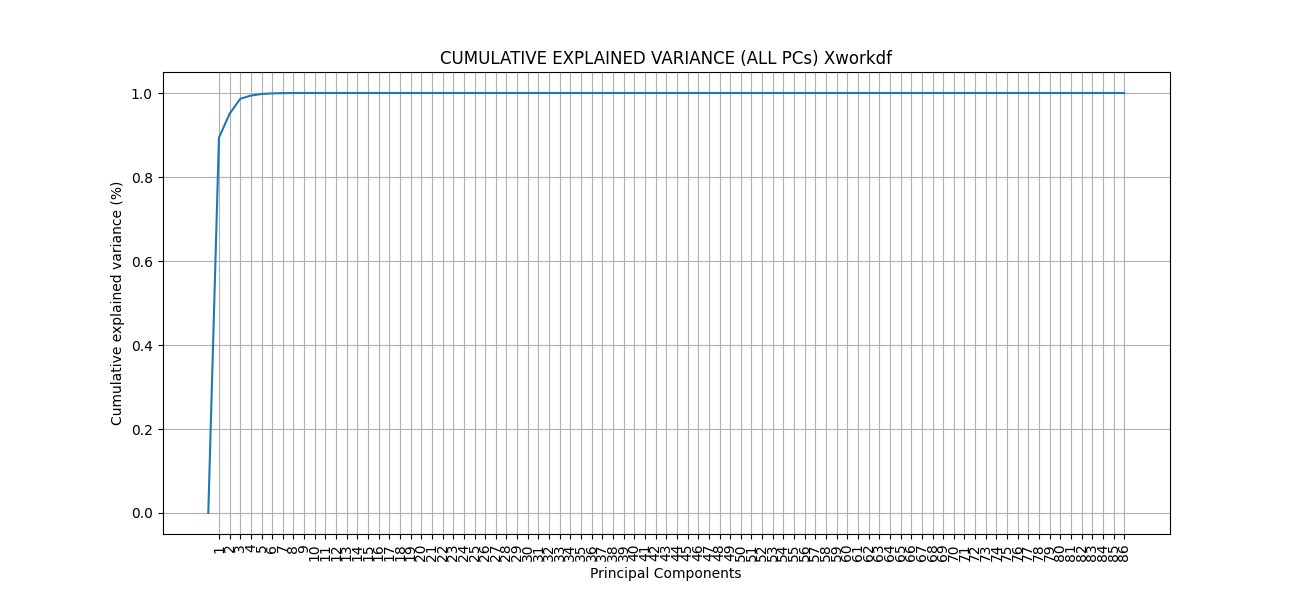

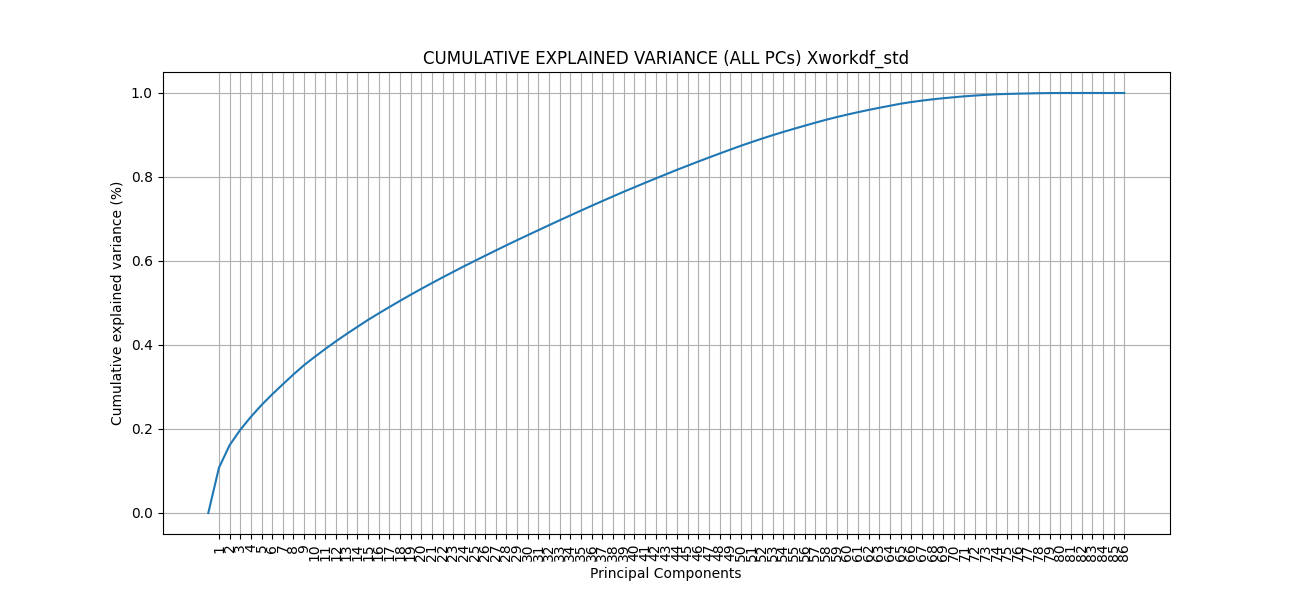

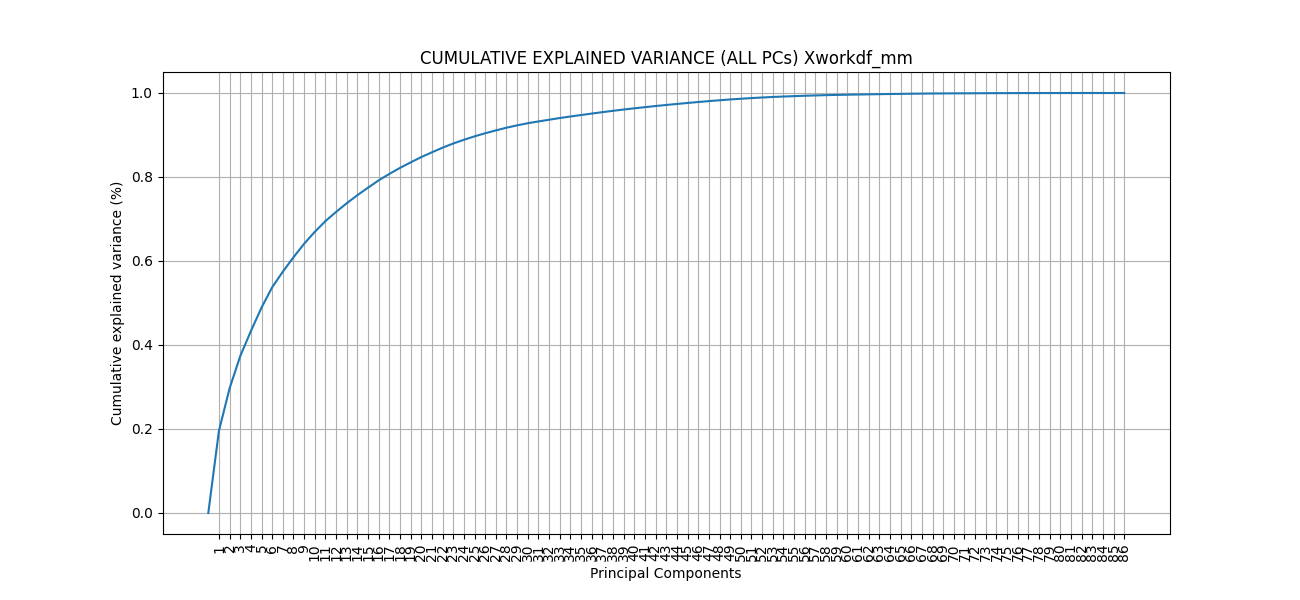

In [31]:
#computation of PCA and cumulative explained variance 
#for standardscaler, minmaxscaler and no preporocessig cases

pca_full = PCA()

pca_full.fit(Xworkdf)
plt.figure(figsize=(13, 6))
plt.plot(np.insert(np.cumsum(pca_full.explained_variance_ratio_), 0, 0))
plt.title('CUMULATIVE EXPLAINED VARIANCE (ALL PCs) Xworkdf')
plt.xticks(ticks=np.arange(1, pca_full.n_features_ + 1), 
           labels=None,
           rotation=90)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variance (%)')
plt.grid()
plt.show()

pca_full.fit(Xworkdf_std)
plt.figure(figsize=(13, 6))
plt.plot(np.insert(np.cumsum(pca_full.explained_variance_ratio_), 0, 0))
plt.title('CUMULATIVE EXPLAINED VARIANCE (ALL PCs) Xworkdf_std')
plt.xticks(ticks=np.arange(1, pca_full.n_features_ + 1), 
           labels=None,
           rotation=90)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variance (%)')
plt.grid()
plt.show()

pca_full.fit(Xworkdf_mm)
plt.figure(figsize=(13, 6))
plt.plot(np.insert(np.cumsum(pca_full.explained_variance_ratio_), 0, 0))
plt.title('CUMULATIVE EXPLAINED VARIANCE (ALL PCs) Xworkdf_mm')
plt.xticks(ticks=np.arange(1, pca_full.n_features_ + 1), 
           labels=None,
           rotation=90)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variance (%)')
plt.grid()
plt.show()

In [32]:
#features dataset statistics

Xworkdf.iloc[:,:9].describe()

Displacement (ccm)   Power (hp)  Torque (Nm)    Bore (mm)  Stroke (mm)  \
count         7150.000000  7150.000000  7150.000000  7150.000000  7150.000000   
mean           617.913566    63.210874    55.969024    74.325403    65.199644   
std            563.404226    51.877033    52.333886    19.242571    18.554488   
min             36.700000     0.687225     0.451186     1.500000     0.000000   
25%            147.625000    17.425000    10.744000    57.000000    53.600000   
50%            475.000000    53.000000    43.342836    76.000000    62.000000   
75%            996.000000   100.000000    91.000000    90.000000    73.000000   
max           8200.000000   502.000000   603.000000   116.000000   458.600000   

       Fuel capacity (lts)  Dry weight (kg)  Wheelbase (mm)  Seat height (mm)  
count          7150.000000      7150.000000     7150.000000       7150.000000  
mean             13.345512       174.934022     1433.830792        789.399093  
std               5.758117        79.777661      159.348453        146.282455  
min              -0.934433        22.000000      745.000000         87.000000  
25%               8.500000       110.000000     1340.000000        744.000000  
50%              14.000000       167.000000     1440.000000        790.000000  
75%              17.410000       213.000000     1510.000000        830.000000  
max              40.000000      1000.000000     2235.000000       7501.000000

Looking at plots it can be seen that some **preprocessing is required** for the dataset. In fact, statistics for numerical features clearly show that some of them have different order of magnitude (for example displacement and fuel capacity). This means that features with higher variability will absorb the majority of explained variance in dimensionality reduction. Not surprisingly, without any standardization there is about 100% of total explained variance with only 9 PCs. A more accurate description of the data is provided in the case of Xworkdf_std and Xworkdf_mm, where with 9 PCs there is moreless 50% and 80% of total explained variance, respectively. 

At this point it is difficult to determine which is the better standardization. This is why in subsequent analysis all the procedures will be repeated for both types of preprocessing. What can observed so far is that StandardScaler gives more "importance" to a larger number of features, while MinMaxScaler has a less conservative approach. 

## Excercise 4 (Dimensionality Reduction and Interpretation of the PCs)

In [33]:
#PCA computation with 35% of explained variance using both standardscaler and minmaxscaler

pca_es4_std=PCA(n_components=0.35)
pca_es4_std.fit(Xworkdf_std)
print('StardardScaler case:')
print(f'Number of features with 35% of explained variance is {len(pca_es4_std.explained_variance_)}, so I have considered {min(len(pca_es4_std.explained_variance_),5)} features for subsequent analysis')#---->min è 5
pca_es4_std=PCA(n_components=5)
pca_es4_std.fit(Xworkdf_std)

print('')
print('MinMaxScaler case:')
pca_es4_mm=PCA(n_components=0.35)
pca_es4_mm.fit(Xworkdf_mm)
print(f'Number of features with 35% of explained variance is {len(pca_es4_mm.explained_variance_)}, so I have considered {min(len(pca_es4_mm.explained_variance_),5)} features for subsequent analysis')#---->min è 3

StardardScaler case:
Number of features with 35% of explained variance is 9, so I have considered 5 features for subsequent analysis

MinMaxScaler case:
Number of features with 35% of explained variance is 3, so I have considered 3 features for subsequent analysis


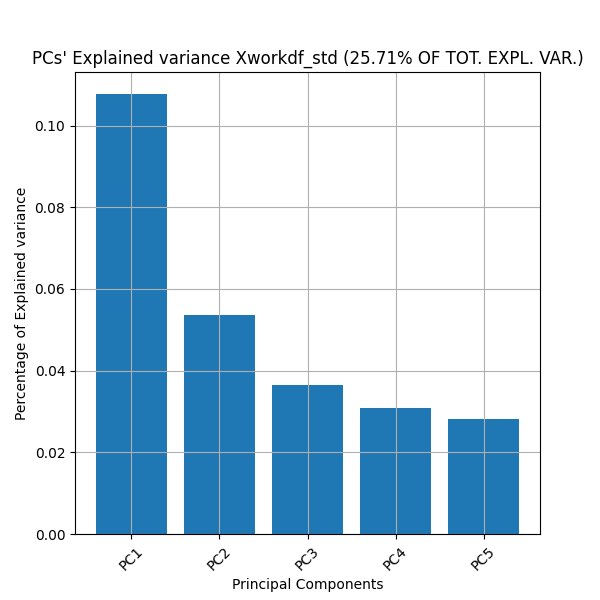

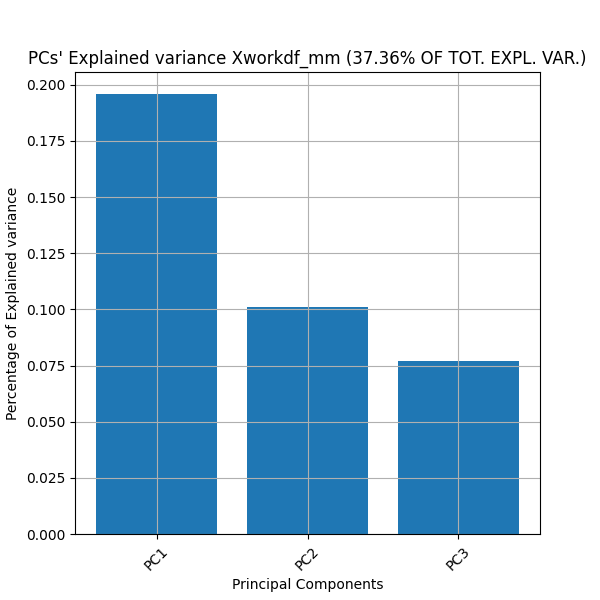

In [34]:
#PCs explained variance barplots

round_expl_var_ratio = np.round(pca_es4_std.explained_variance_ratio_.sum() * 100, decimals=2)
m_std=pca_es4_std.n_components
plt.figure(figsize=(6,6))
plt.bar(range(1, m_std + 1), pca_es4_std.explained_variance_ratio_)
plt.title(f"PCs' Explained variance Xworkdf_std ({round_expl_var_ratio}% OF TOT. EXPL. VAR.)")
plt.xticks(ticks=np.arange(1, m_std + 1), 
           labels=[f'PC{i}' for i in range(1, m_std + 1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained variance')
plt.grid()
plt.show()

round_expl_var_ratio = np.round(pca_es4_mm.explained_variance_ratio_.sum() * 100, decimals=2)
m_mm=len(pca_es4_mm.explained_variance_)
plt.figure(figsize=(6,6))
plt.bar(range(1, m_mm + 1), pca_es4_mm.explained_variance_ratio_)
plt.title(f"PCs' Explained variance Xworkdf_mm ({round_expl_var_ratio}% OF TOT. EXPL. VAR.)")
plt.xticks(ticks=np.arange(1, m_mm + 1), 
           labels=[f'PC{i}' for i in range(1, m_mm + 1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained variance')
plt.grid()
plt.show()

Looking at PCs barplots it can be obsserved that in both cases the last PCs (fourth and fifth for StandardScaler, third for MinMaxScaler) do not have a high percentage of explainded variance. Therefore, I expect them to be diffucult to interpret. For this reason, I decided to take inspiration from what was done in the laboratory about Fifa '19 and **associate each feature to a particular unit of measurement and category**.  

Possible values for units of measurement are: meters, squared meters, newton-meters, kilograms, liters, horsepower, counting measures (such as the number of gears in transmission) and no unit of measurement (such as fuel system). In the following parts I will refer to the values 'counting measures' and 'no unit of measurement' respectively with 'cardinality' and 'no_udm'.  

Possible categories are: brakes, tire, suspension, fuel, cooling system (later called only cooling), transmission, cylinder, power and size. The last attribute refers to all the features that in some sense are related with the size of motorcycles.  

This criteria were defined looking at features meaning. The hope is that they can help in PCs interpretation.

In [35]:
#definition of units of measurement dataset

features=['Bore (mm)','Stroke (mm)','Wheelbase (mm)','Seat height (mm)',
          'Displacement (ccm)','Torque (Nm)','Dry weight (kg)',
          'Fuel capacity (lts)','Power (hp)']
measures=['meters','meters','meters','meters','cubic meters',
          'newton-meters','kilograms','liters','horsepower']
feat_mancanti=list(Xworkdf.columns[9:])
for i in range(len(feat_mancanti)):
    features.append(feat_mancanti[i])
    if i<46:
        measures.append('cardinality')
    else:
        measures.append('no_udm')
df_features_measures=pd.DataFrame(index=list(range(len(features))),
                                  columns=['features','measure_type'])
df_features_measures.loc[:,'features']=features
df_features_measures.loc[:,'measure_type']=measures

In [36]:
#definition of categories dataset

features=['Bore (mm)','Stroke (mm)','Power (hp)','Torque (Nm)',
          'Displacement (ccm)','Dry weight (kg)',
          'Wheelbase (mm)','Seat height (mm)',
          'Fuel capacity (lts)']
categories=['cylinder','cylinder','power','power','size','size',
         'size','size','Fuel']
possible_categories=['cylinder','power','size','Fuel','Cooling','Transmission',
                    'suspension','tire','brakes','not given']
cat_mancanti=list(Xworkdf.columns[9:])
for i in range(len(cat_mancanti)):
    features.append(cat_mancanti[i])
    if 'Gearbox' in cat_mancanti[i]:
        categories.append('Transmission')
    elif 'stroke' in cat_mancanti[i]:
        categories.append('cylinder')
    elif 'Fuel control_Membrane & power valve' in cat_mancanti[i]:
        categories.append('Fuel')
    else:
        for j in range(len(possible_categories)):
            if possible_categories[j] in cat_mancanti[i]:
                categories.append(possible_categories[j])
df_features_categories=pd.DataFrame(index=list(range(len(features))),
                                    columns=['features','categories'])
df_features_categories.loc[:,'features']=features
df_features_categories.loc[:,'categories']=categories

In [37]:
#definition of colors to be used for both units of measurement and categories

meas_uniq=pd.unique(df_features_measures.iloc[:,1])
cat_uniq=pd.unique(df_features_categories.iloc[:,1])
set20 = cm.tab20.colors

meas_colors=dict(zip(meas_uniq,set20[0:8]))
cat_colors =dict(zip(cat_uniq,set20[0:10]))

In [38]:
#adding colors column to the previous datasets

df_features_measures['color'] = [meas_colors[t] for t in df_features_measures['measure_type'].values]
df_features_categories['color'] = [cat_colors[t] for t in df_features_categories['categories'].values]

display(df_features_measures)
display(df_features_categories)

features  measure_type  \
0                                           Bore (mm)        meters   
1                                         Stroke (mm)        meters   
2                                      Wheelbase (mm)        meters   
3                                    Seat height (mm)        meters   
4                                  Displacement (ccm)  cubic meters   
..                                                ...           ...   
81                        Rear suspension_twin shocks        no_udm   
82                        Rear suspension_dual shocks        no_udm   
83                          Rear suspension_monoshock        no_udm   
84  Rear suspension_link type, coil spring, oil da...        no_udm   
85                                          not given        no_udm   

                                                color  
0   (0.12156862745098039, 0.4666666666666667, 0.70...  
1   (0.12156862745098039, 0.4666666666666667, 0.70...  
2   (0.12156862745098039, 0.4666666666666667, 0.70...  
3   (0.12156862745098039, 0.4666666666666667, 0.70...  
4   (0.6823529411764706, 0.7803921568627451, 0.909...  
..                                                ...  
81       (1.0, 0.596078431372549, 0.5882352941176471)  
82       (1.0, 0.596078431372549, 0.5882352941176471)  
83       (1.0, 0.596078431372549, 0.5882352941176471)  
84       (1.0, 0.596078431372549, 0.5882352941176471)  
85       (1.0, 0.596078431372549, 0.5882352941176471)  

[86 rows x 3 columns]

features  categories  \
0                                           Bore (mm)    cylinder   
1                                         Stroke (mm)    cylinder   
2                                          Power (hp)       power   
3                                         Torque (Nm)       power   
4                                  Displacement (ccm)        size   
..                                                ...         ...   
81                        Rear suspension_twin shocks  suspension   
82                        Rear suspension_dual shocks  suspension   
83                          Rear suspension_monoshock  suspension   
84  Rear suspension_link type, coil spring, oil da...  suspension   
85                                          not given   not given   

                                                color  
0   (0.12156862745098039, 0.4666666666666667, 0.70...  
1   (0.12156862745098039, 0.4666666666666667, 0.70...  
2   (0.6823529411764706, 0.7803921568627451, 0.909...  
3   (0.6823529411764706, 0.7803921568627451, 0.909...  
4     (1.0, 0.4980392156862745, 0.054901960784313725)  
..                                                ...  
81  (0.5803921568627451, 0.403921568627451, 0.7411...  
82  (0.5803921568627451, 0.403921568627451, 0.7411...  
83  (0.5803921568627451, 0.403921568627451, 0.7411...  
84  (0.5803921568627451, 0.403921568627451, 0.7411...  
85  (0.7725490196078432, 0.6901960784313725, 0.835...  

[86 rows x 3 columns]

Two datasets were built to map each feature to an unique unit of measurment and category. Different colors were associated within the set of possible units of measurement and categories. Plotting PCs using this colors can help understand possible correlation between features.

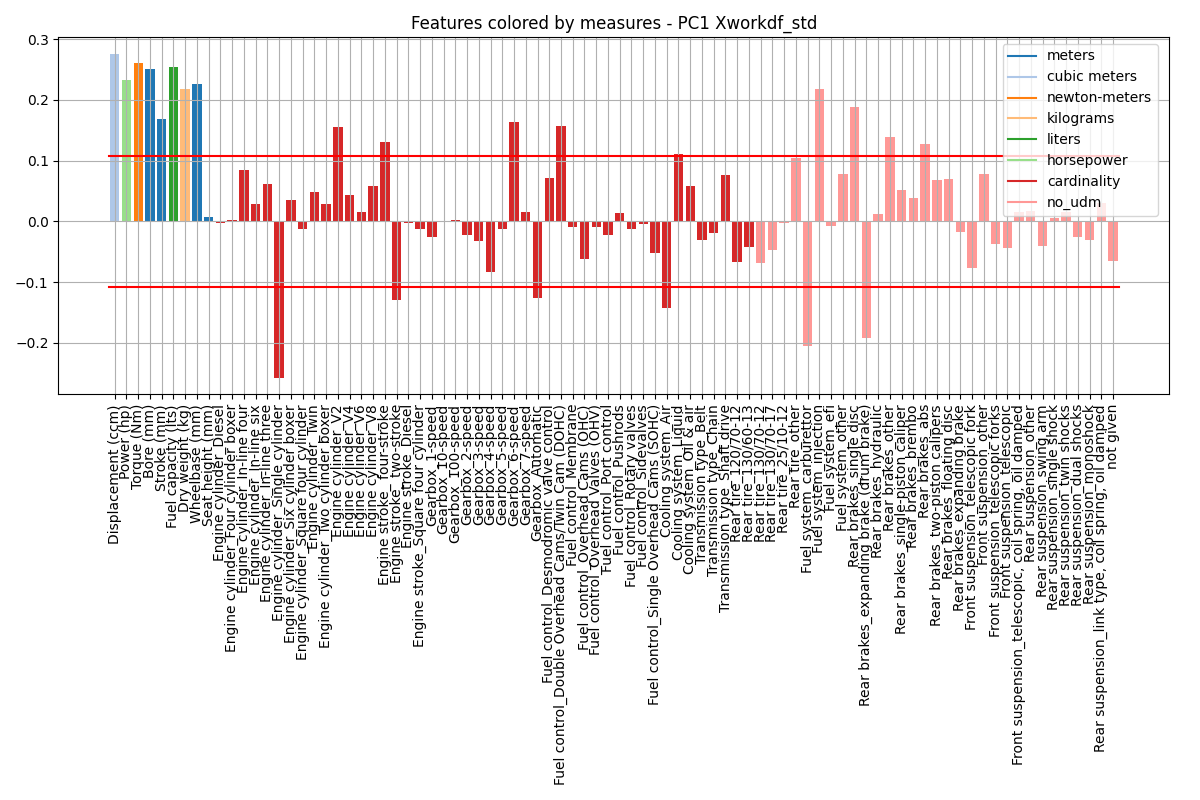

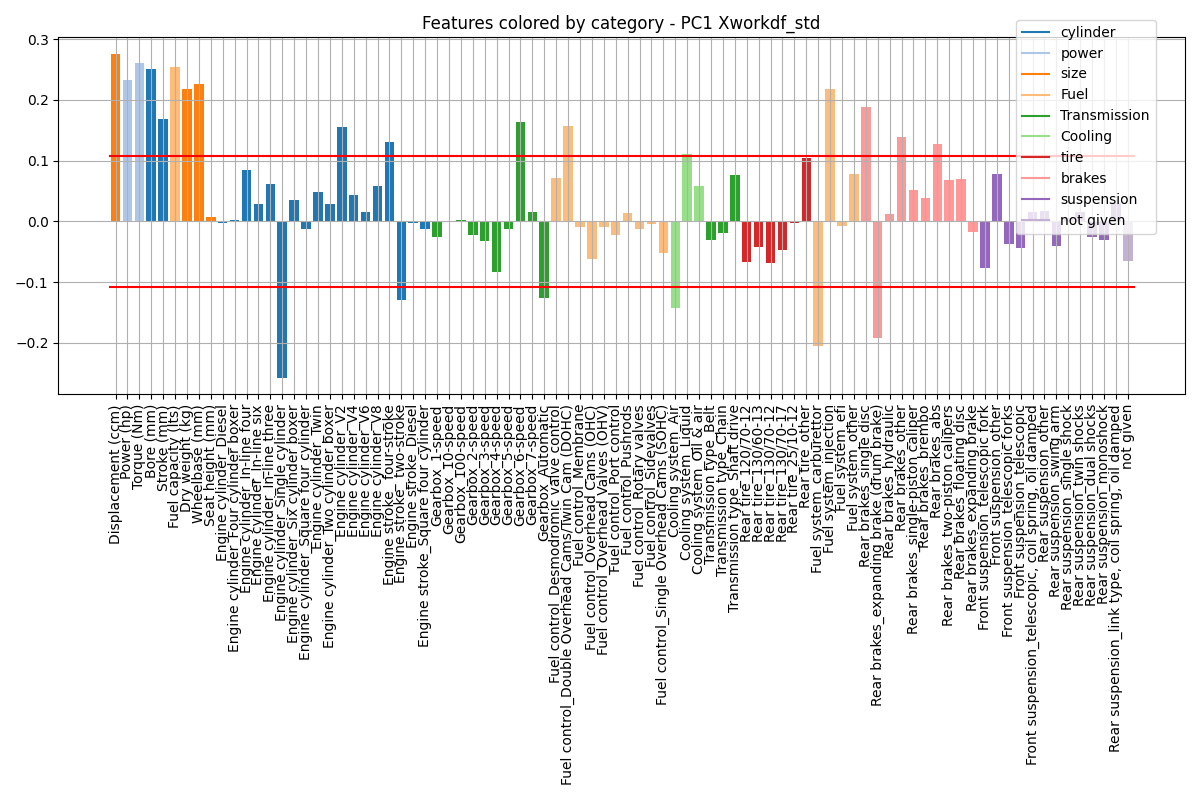


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Displacement (ccm)', 'Power (hp)', 'Torque (Nm)', 'Bore (mm)', 'Stroke (mm)', 'Fuel capacity (lts)', 'Dry weight (kg)', 'Wheelbase (mm)', 'Engine cylinder_V2', 'Engine stroke_ four-stroke', 'Gearbox_6-speed', 'Fuel control_Double Overhead Cams/Twin Cam (DOHC)', 'Cooling system_Liquid', 'Fuel system_injection', 'Rear brakes_single disc', 'Rear brakes_other', 'Rear brakes_abs']

HIGH-VALUED NEGATIVE COMPONENTS: ['Engine cylinder_Single cylinder', 'Engine stroke_ two-stroke', 'Gearbox_Automatic', 'Cooling system_Air', 'Fuel system_carburettor', 'Rear brakes_expanding brake (drum brake)']
*********************************************



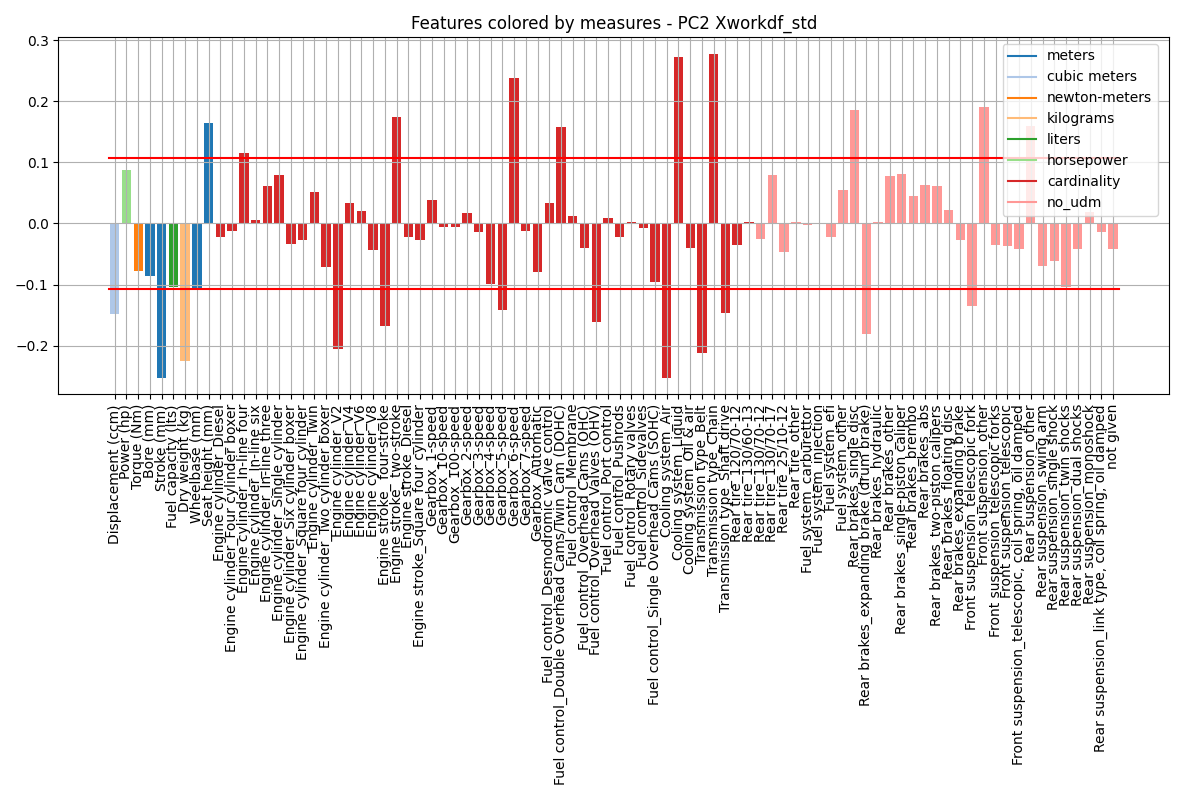

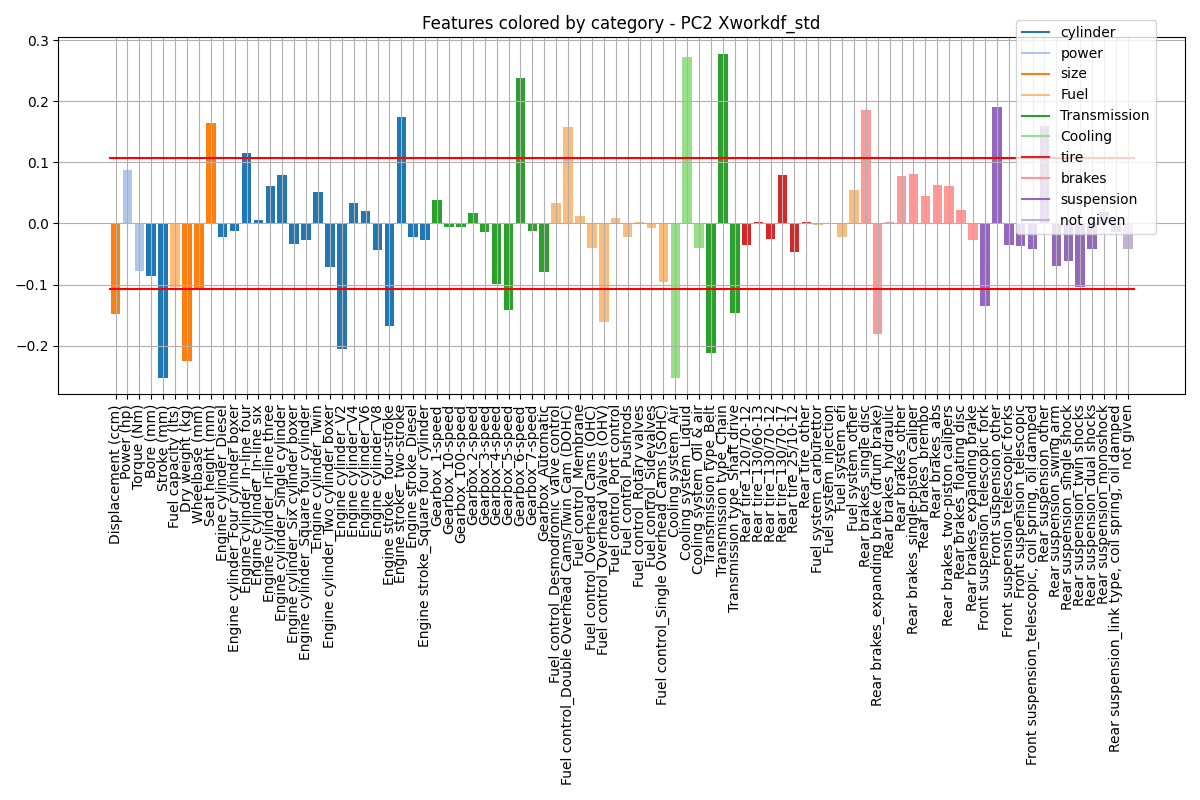


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Seat height (mm)', 'Engine cylinder_In-line four', 'Engine stroke_ two-stroke', 'Gearbox_6-speed', 'Fuel control_Double Overhead Cams/Twin Cam (DOHC)', 'Cooling system_Liquid', 'Transmission type_Chain', 'Rear brakes_single disc', 'Front suspension_other', 'Rear suspension_other']

HIGH-VALUED NEGATIVE COMPONENTS: ['Displacement (ccm)', 'Stroke (mm)', 'Dry weight (kg)', 'Wheelbase (mm)', 'Engine cylinder_V2', 'Engine stroke_ four-stroke', 'Gearbox_5-speed', 'Fuel control_Overhead Valves (OHV)', 'Cooling system_Air', 'Transmission type_Belt', 'Transmission type_Shaft drive', 'Rear brakes_expanding brake (drum brake)', 'Front suspension_telescopic fork']
*********************************************



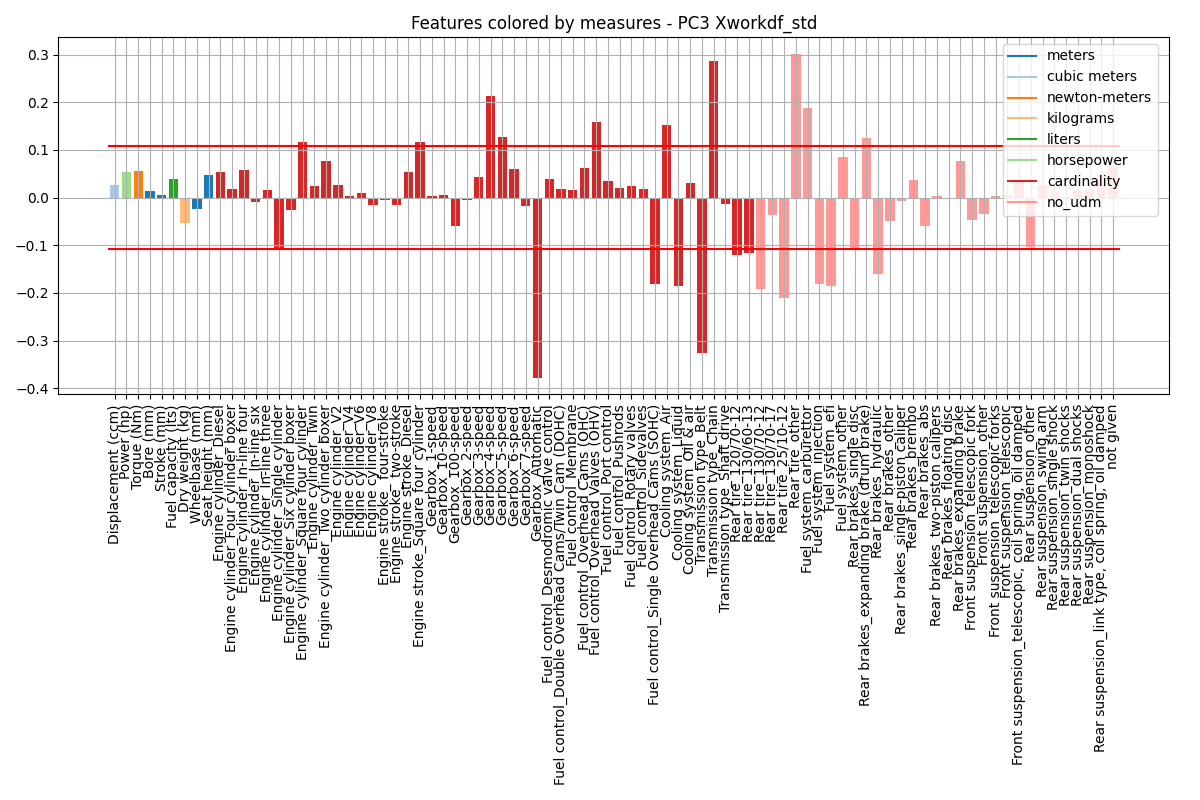

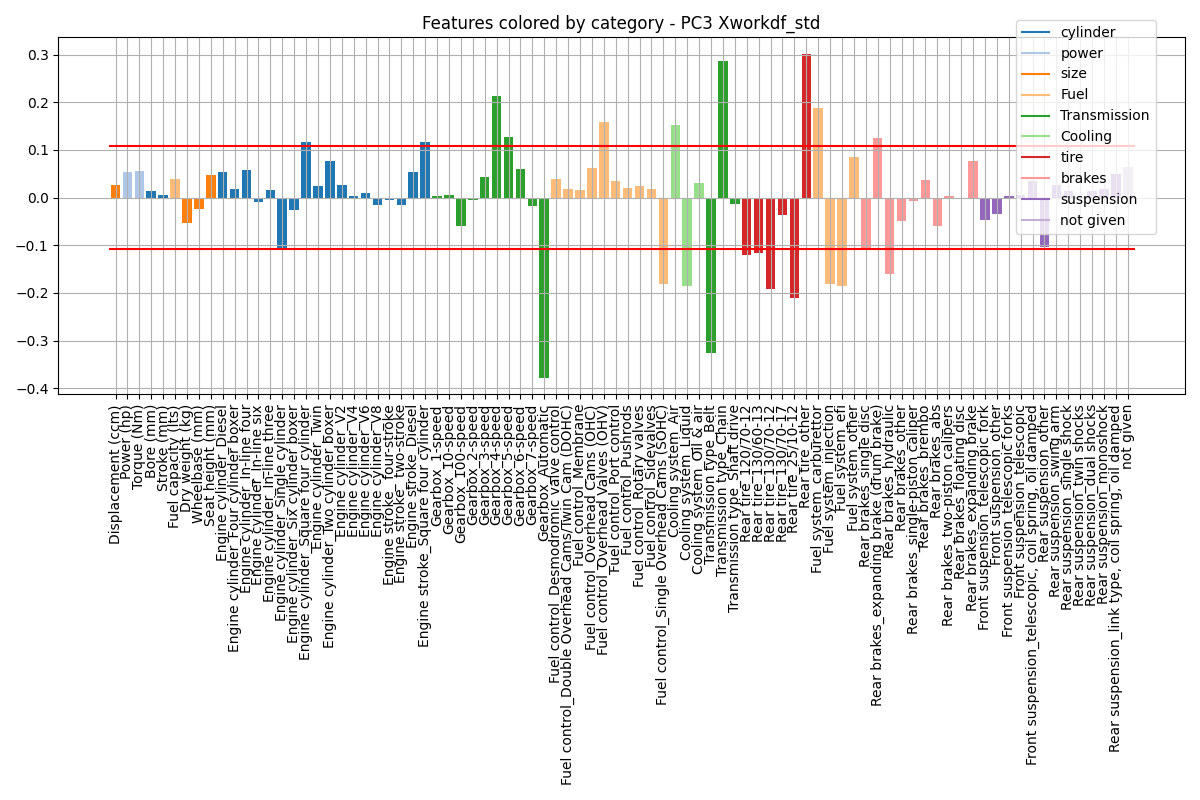


****************** PC3 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Engine cylinder_Square four cylinder', 'Engine stroke_Square four cylinder', 'Gearbox_4-speed', 'Gearbox_5-speed', 'Fuel control_Overhead Valves (OHV)', 'Cooling system_Air', 'Transmission type_Chain', 'Rear tire_other', 'Fuel system_carburettor', 'Rear brakes_expanding brake (drum brake)']

HIGH-VALUED NEGATIVE COMPONENTS: ['Gearbox_Automatic', 'Fuel control_Single Overhead Cams (SOHC)', 'Cooling system_Liquid', 'Transmission type_Belt', 'Rear tire_120/70-12', 'Rear tire_130/60-13', 'Rear tire_130/70-12', 'Rear tire_25/10-12', 'Fuel system_injection', 'Fuel system_efi', 'Rear brakes_single disc', 'Rear brakes_hydraulic']
*********************************************



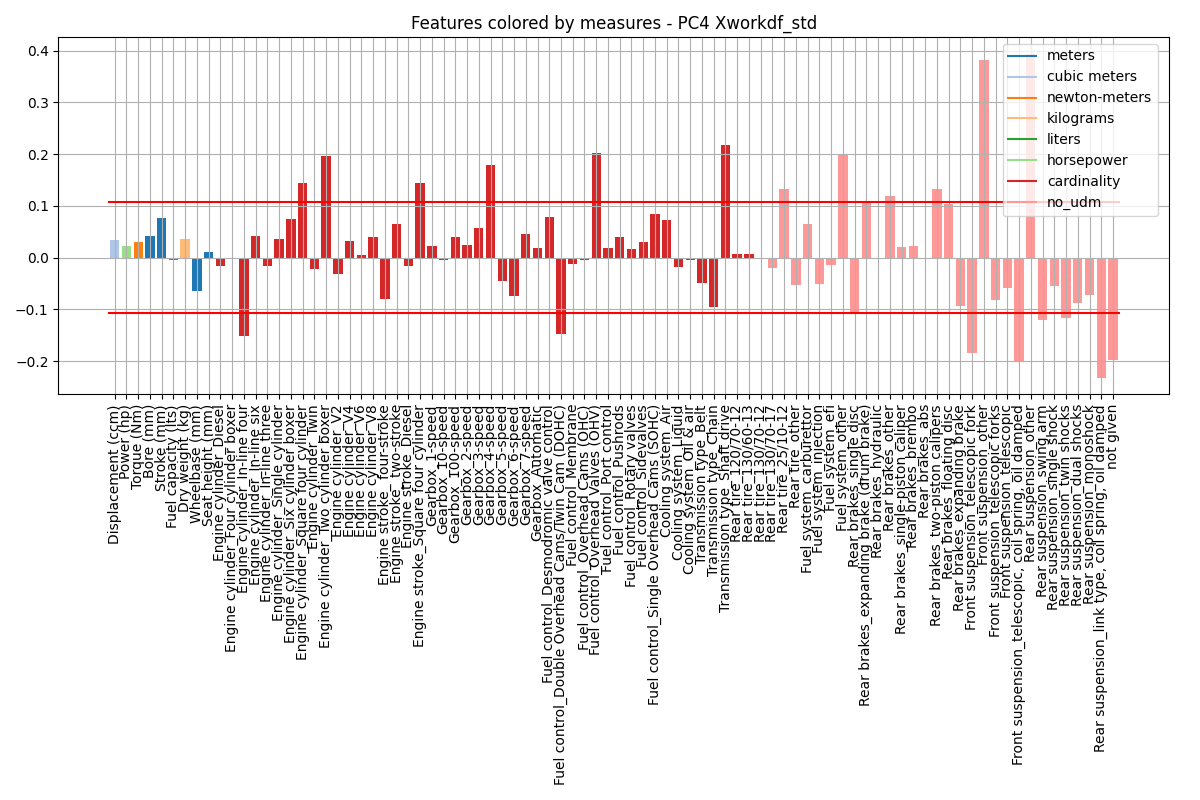

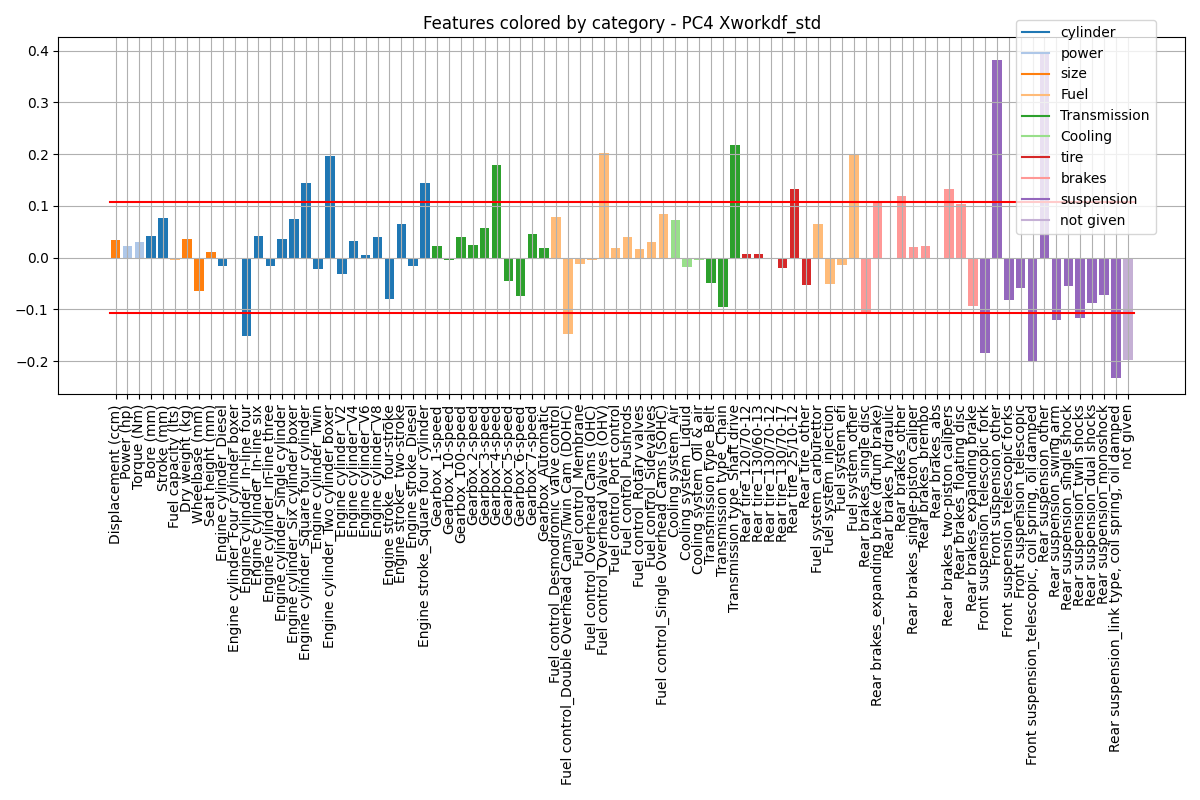


****************** PC4 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Engine cylinder_Square four cylinder', 'Engine cylinder_Two cylinder boxer', 'Engine stroke_Square four cylinder', 'Gearbox_4-speed', 'Fuel control_Overhead Valves (OHV)', 'Transmission type_Shaft drive', 'Rear tire_25/10-12', 'Fuel system_other', 'Rear brakes_other', 'Rear brakes_two-piston calipers', 'Front suspension_other', 'Rear suspension_other']

HIGH-VALUED NEGATIVE COMPONENTS: ['Engine cylinder_In-line four', 'Fuel control_Double Overhead Cams/Twin Cam (DOHC)', 'Front suspension_telescopic fork', 'Front suspension_telescopic, coil spring, oil damped', 'Rear suspension_swing arm', 'Rear suspension_twin shocks', 'Rear suspension_link type, coil spring, oil damped', 'not given']
*********************************************



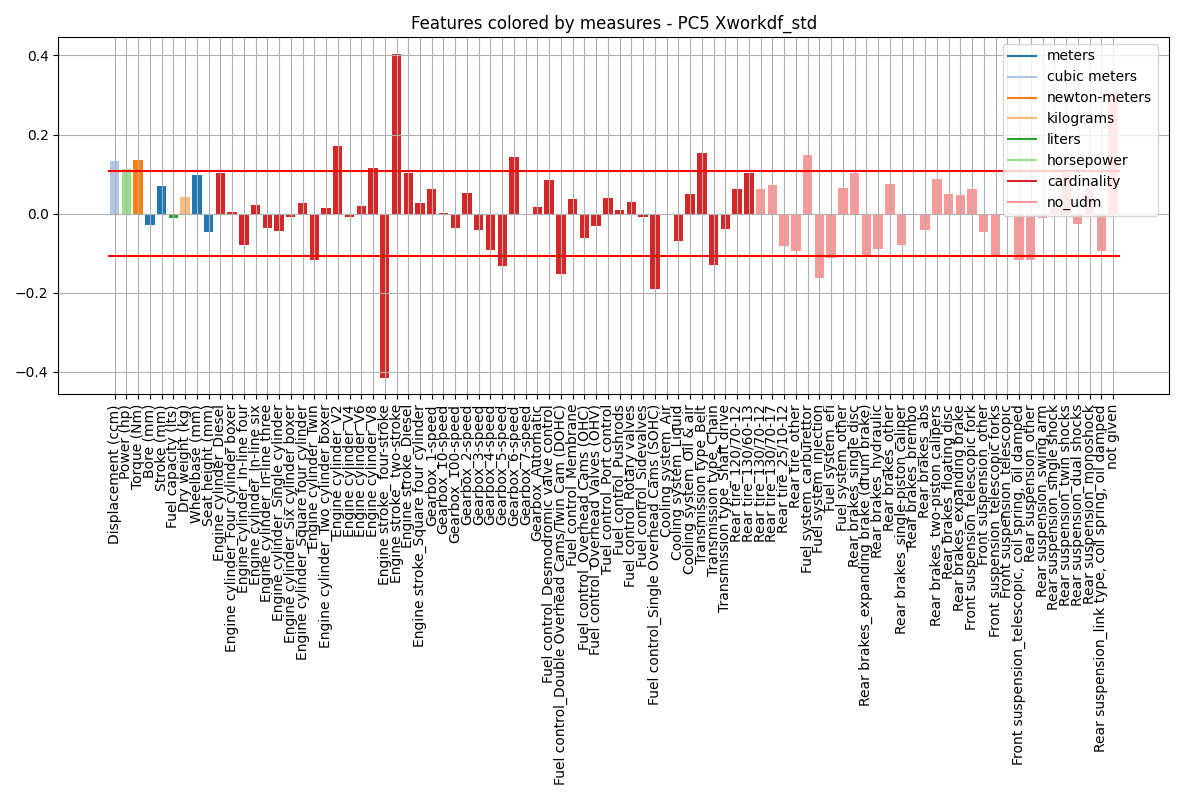

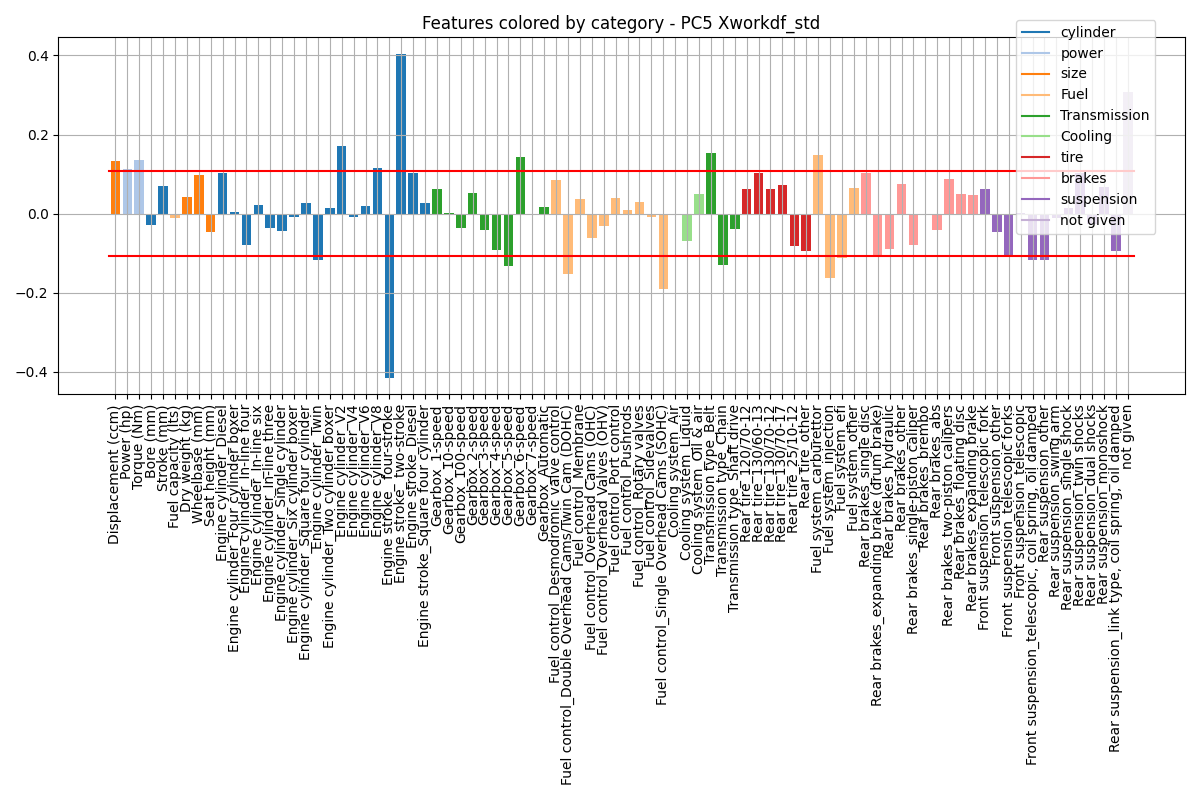


****************** PC5 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Displacement (ccm)', 'Power (hp)', 'Torque (Nm)', 'Engine cylinder_V2', 'Engine cylinder_V8', 'Engine stroke_ two-stroke', 'Gearbox_6-speed', 'Transmission type_Belt', 'Fuel system_carburettor', 'not given']

HIGH-VALUED NEGATIVE COMPONENTS: ['Engine cylinder_Twin', 'Engine stroke_ four-stroke', 'Gearbox_5-speed', 'Fuel control_Double Overhead Cams/Twin Cam (DOHC)', 'Fuel control_Single Overhead Cams (SOHC)', 'Transmission type_Chain', 'Fuel system_injection', 'Fuel system_efi', 'Front suspension_telescopic, coil spring, oil damped', 'Rear suspension_other']
*********************************************



In [39]:
#barplots of PCs with respect to units of measurement and categories coloring (standardscaler case)

eps = np.sqrt(1 / pca_es4_std.n_features_)

features_colors_measures = [df_features_measures.loc[df_features_measures['features'] == s]['color'].values[0] for s in Xworkdf.columns]
features_colors_cat = [df_features_categories.loc[df_features_categories['features'] == s]['color'].values[0] for s in Xworkdf.columns]

meas_colors_legend = [Line2D([0], [0], color=meas_colors[k]) for k in meas_colors.keys()]
cat_colors_legend = [Line2D([0], [0], color=cat_colors[k]) for k in cat_colors.keys()]
for ii in range(m_std):
    plt.figure(figsize=(12, 8))
    plt.bar(np.arange(pca_es4_std.n_features_), pca_es4_std.components_[ii, :], 
            color=features_colors_measures)
    plt.plot([-0.5, pca_es4_std.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_es4_std.n_features_ - 0.5], [-eps, -eps], 'red')
    plt.xticks(ticks=np.arange(pca_es4_std.n_features_), 
               labels=Xworkdf.columns,
               rotation=90)
    plt.title(f'Features colored by measures - PC{ii + 1} Xworkdf_std')
    plt.legend(meas_colors_legend, [k for k in meas_colors.keys()],loc=(0.85,0.5))
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    plt.bar(np.arange(pca_es4_std.n_features_), pca_es4_std.components_[ii, :], 
            color=features_colors_cat)
    plt.plot([-0.5, pca_es4_std.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_es4_std.n_features_ - 0.5], [-eps, -eps], 'red')
    plt.xticks(ticks=np.arange(pca_es4_std.n_features_), 
               labels=Xworkdf.columns,
               rotation=90)
    plt.title(f'Features colored by category - PC{ii + 1} Xworkdf_std')
    plt.legend(cat_colors_legend, [k for k in cat_colors.keys()],loc=(0.85,0.45))
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    ind_great_pos_PCii = np.argwhere(pca_es4_std.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_es4_std.components_[ii, :] <= -eps).flatten()
    great_pos_PCii = [Xworkdf.columns[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [Xworkdf.columns[i] for i in ind_great_neg_PCii]
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')

Looking at PCs it is possible to give them a name. To do this, I have set a threshold on the plots (red horizontal line) to consider only significant features within the PCs. It is important to underline that this threshold is completely arbitrary and I thought its value was flexible during the naming phase. I am not an expert about motorcycles however I thounght that in typical company situation there are experts who know technical information and possible relations between features. Therefore, I decide to use ChatGPT as experienced counterpart to help me understand better features meaning. I kept the chat I carried out with ChapGPT and I have no problem sharing it to show that it was only used to ask purely technical information about motorcycles.

1. **PC1 Standard Scaler: Powerful, comfortable, expensive (+) VS lightweight, cheap (-) motorcycles**   
PC1 distinguishes these two macroareas of motorcycles. The characteristics that helped me identify the two categories are cylinder, stroke, and gearbox types (see PC1 high-valued positive and negative components for exact features values). However, it is important to note that the distinction is made primarily in terms of **measurable features** such as displacement, torque, and bore, which are useful, for example, in characterizing powerful motorcycles. This highlights a very relevant aspect of PCA. In fact, without using it I was not able to clearly understand the order of magnitude of the numerical features. Actually, the reduction of dimensionality shed more light on their meaning and association with certain categories of motorcycles. Finally, thanks to this PC, it is possible to assume that the category "Rear Brakes Other" contains mainly technological and high-performance brake types, since it has a positive PC1 component.

2. **PC2 Standard Scaler: Most powerful, racing (+) VS middle/high performance (-) motorcycles**  
This split is in terms of **fuel system, transmission type, brake type and cooling system**. These features describe how well the engine uses fuel and air to produce power, how smoothly and efficiently it runs, and how much power can be delivered to the wheels. One might think that this PC is similar to the first one, since it comparing again high and low performance motorcycles. However, it is important to see that this comparison is made mainly through numerical features for PC1 and with categorical ones for PC2. Furthermore, PC1 features with high/low components are those that belong to the power category, whereas PC2 features influence power but do not really represent it. For example, regarding brakes types, it is realistic that more powerful motorcycles have more advanced breaking systems to provide better stopping power and handling at high speeds. PC2 highlights this because more advanced brakes, such as single disc ones, have got a positive component while drum brake (less sophisticated) have a negative component. It is also important to note that PC1 is about both power and ergonomics, while PC2 focuses only on power by separating it better into subcategories. 

3. **PC3 Standard Scaler: Long distance motorcycles (+) VS city bikes (-)**    
This PC is able to separate motorbikes with defined rear tire (negative PC3 component) from motorbikes with value 'Rear tire other' (positive PC3 component). I decided to give this name because motorcycles with automatic gearbox and belt trasmission (typical in scooters or similar) have a negative PC3 componet while non automatic gearbox with chain trasmission (typical in touring motorcycles or similar) are more likely to have positive PC3 component. Similarly to what is done for PC1, it can be guessed that **'Rear tire other'** is associated mainly with more expensive and high performance motorbikes (since it has got positive PC2 component. 

4. **PC4 Standard Scaler: Other (+) VS defined (-) suspension types**    
PC4 is about front and rear suspension types. It is important to see that feature **'not given'** starts to have a negative contribution in this PC. This may imply that samples classification basing on PC4 is affected by a consistent degree of uncertainty. Thanks to the preprocessing used, I was able to map the degree of uncertainty (due to missing values) into something more concrete and this can result useful for subsequent analysis. Types of defined suspensions with high PC3 contribution are: link type, coil spring, oil damped and telescopic fork. These are typical of Allround motorcycles and Naked bikes which are standard motorbikes designed for everyday transportation. Unfortunately in this case it can not be guessed anything about 'suspension type other' because the range of standard motorcycles is very wide and covers both high-performance and economic ones.

5. **PC5 Standard Scaler: Two-stroke engines (+) VS four-stroke engine (-)**    
Like the last two PCs, here motorcycles are separated basing on a **specific characteristic** rather than a group of features. The reason behind this may be related to the fact that PCs barplots of explained variance have got very low contribution for PC3, PC4 and PC5 with respect to the total explained variance. Also for PC5 feature 'not given' has a relative component, positive in this case, so more related to two-strokes motorcycles.

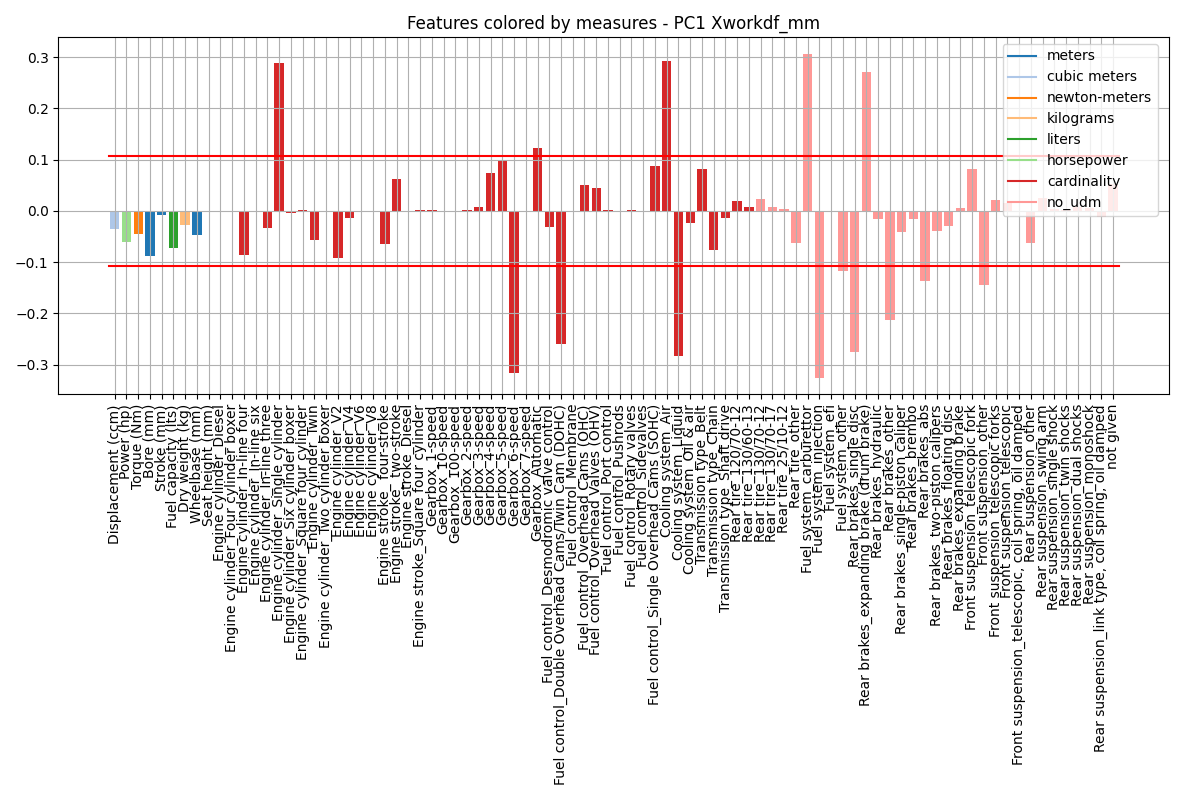

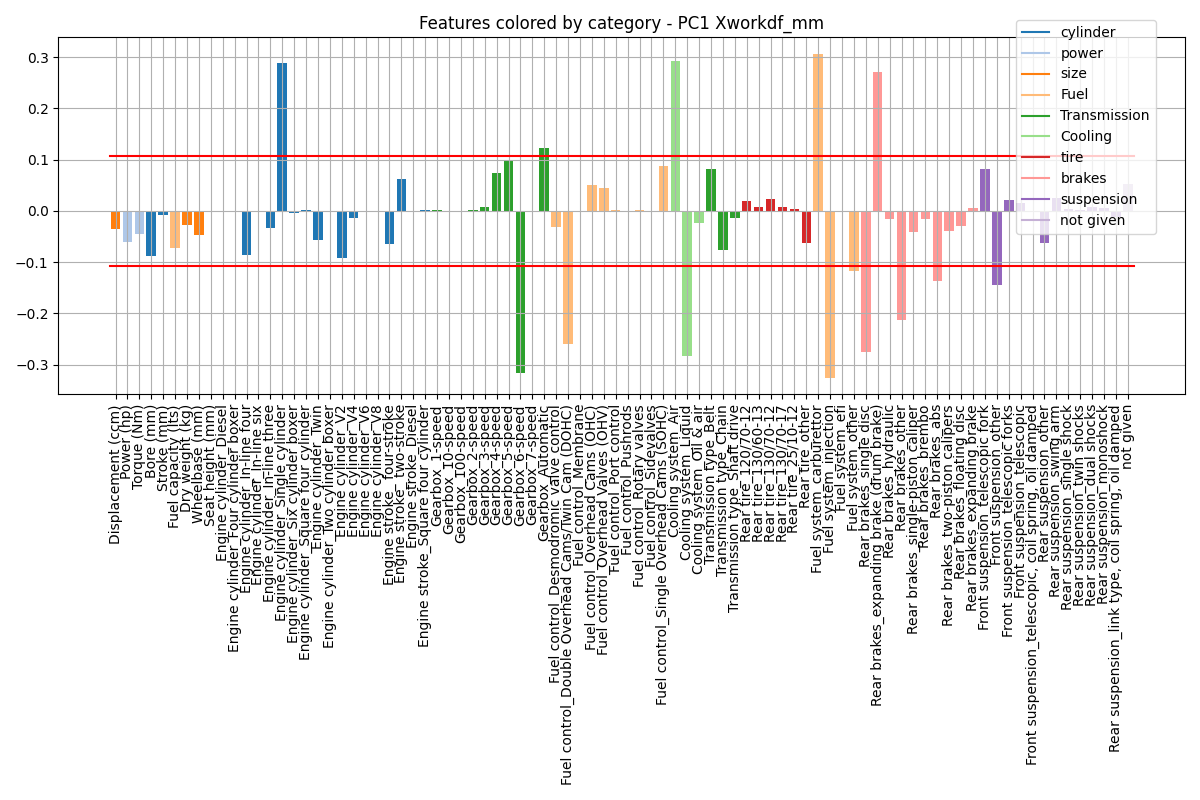


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Engine cylinder_Single cylinder', 'Gearbox_Automatic', 'Cooling system_Air', 'Fuel system_carburettor', 'Rear brakes_expanding brake (drum brake)']

HIGH-VALUED NEGATIVE COMPONENTS: ['Gearbox_6-speed', 'Fuel control_Double Overhead Cams/Twin Cam (DOHC)', 'Cooling system_Liquid', 'Fuel system_injection', 'Fuel system_other', 'Rear brakes_single disc', 'Rear brakes_other', 'Rear brakes_abs', 'Front suspension_other']
*********************************************



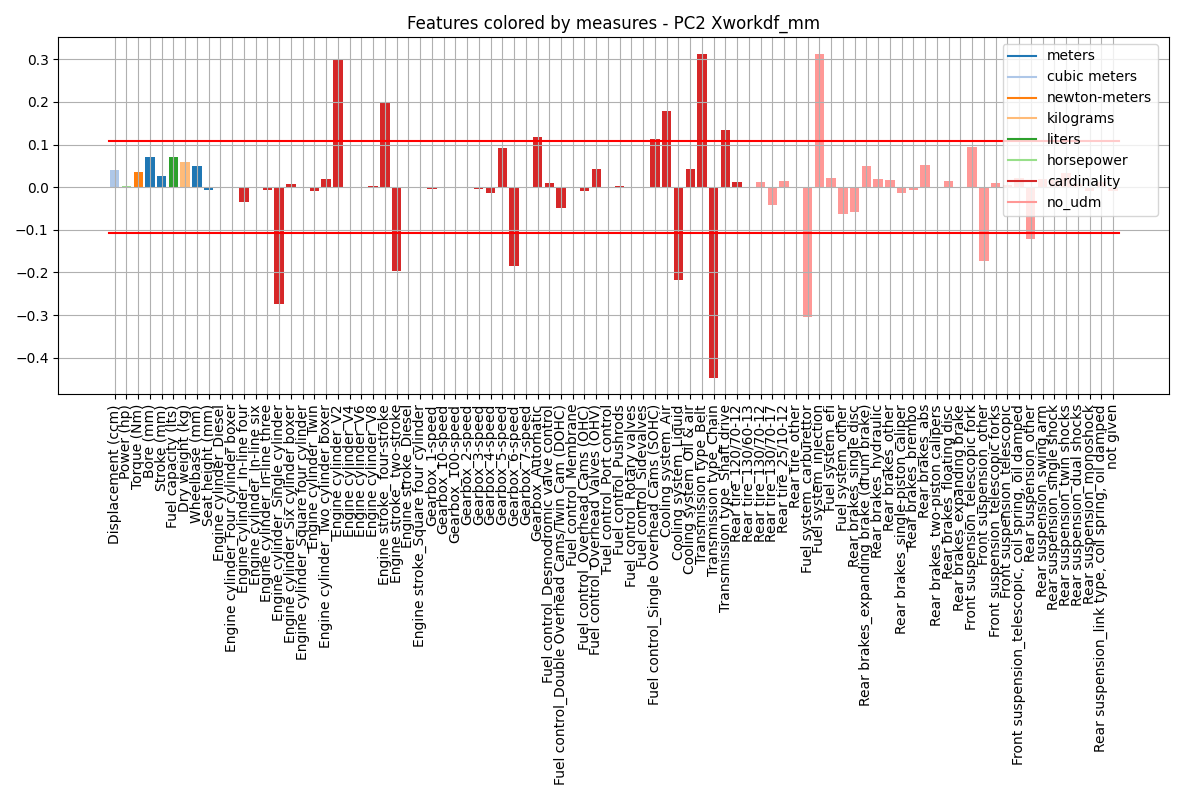

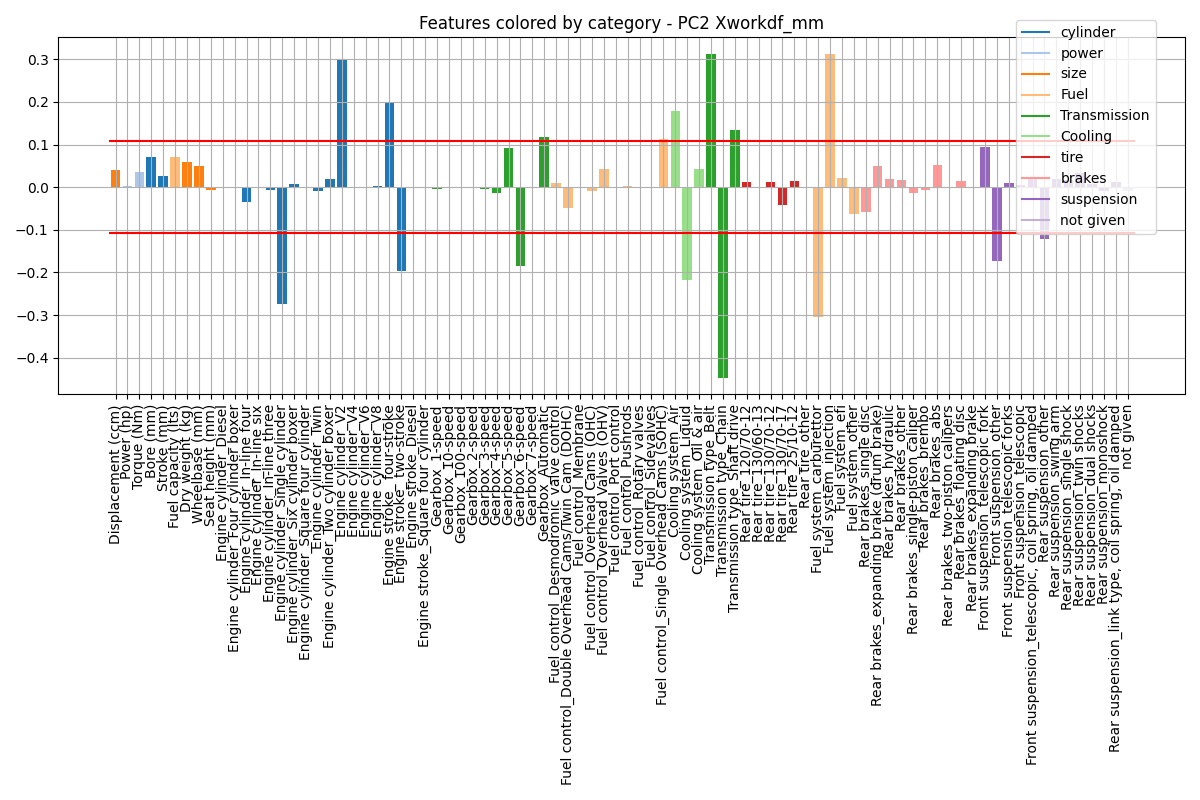


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Engine cylinder_V2', 'Engine stroke_ four-stroke', 'Gearbox_Automatic', 'Fuel control_Single Overhead Cams (SOHC)', 'Cooling system_Air', 'Transmission type_Belt', 'Transmission type_Shaft drive', 'Fuel system_injection']

HIGH-VALUED NEGATIVE COMPONENTS: ['Engine cylinder_Single cylinder', 'Engine stroke_ two-stroke', 'Gearbox_6-speed', 'Cooling system_Liquid', 'Transmission type_Chain', 'Fuel system_carburettor', 'Front suspension_other', 'Rear suspension_other']
*********************************************



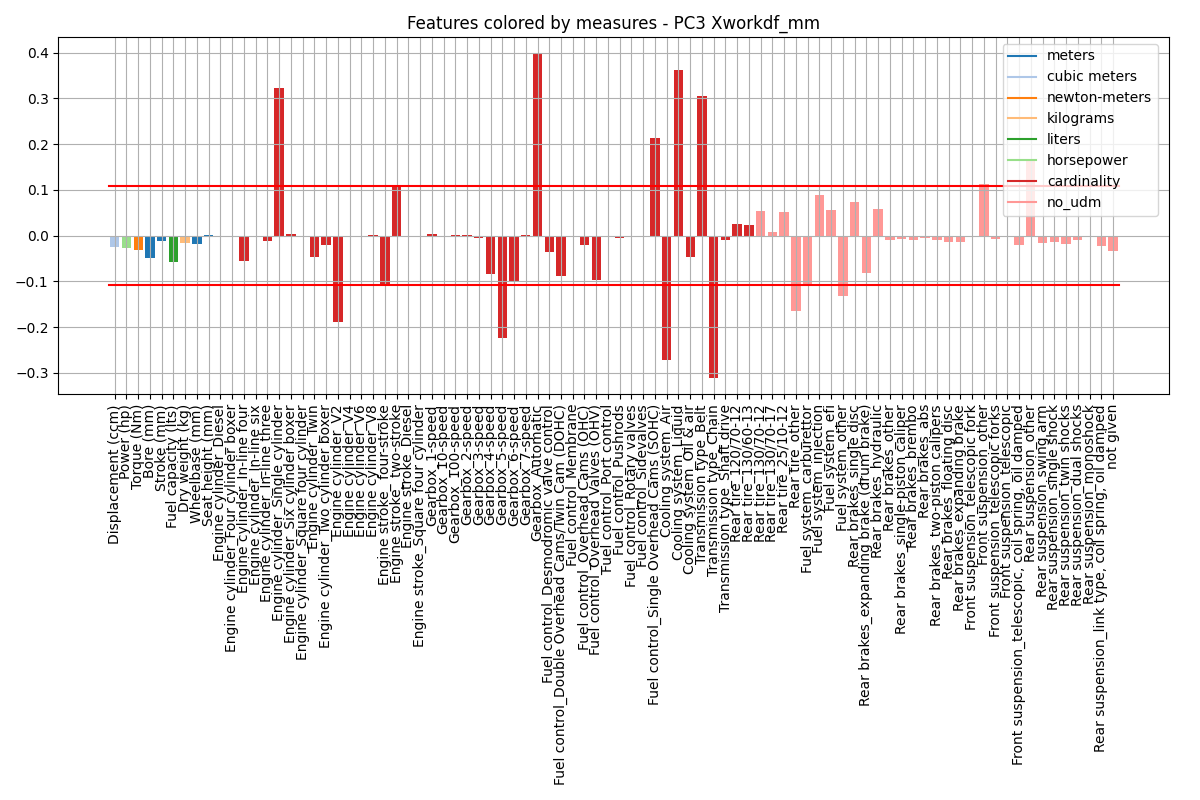

C:\Users\filip\AppData\Local\Temp/ipykernel_15620/1230755311.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 8))


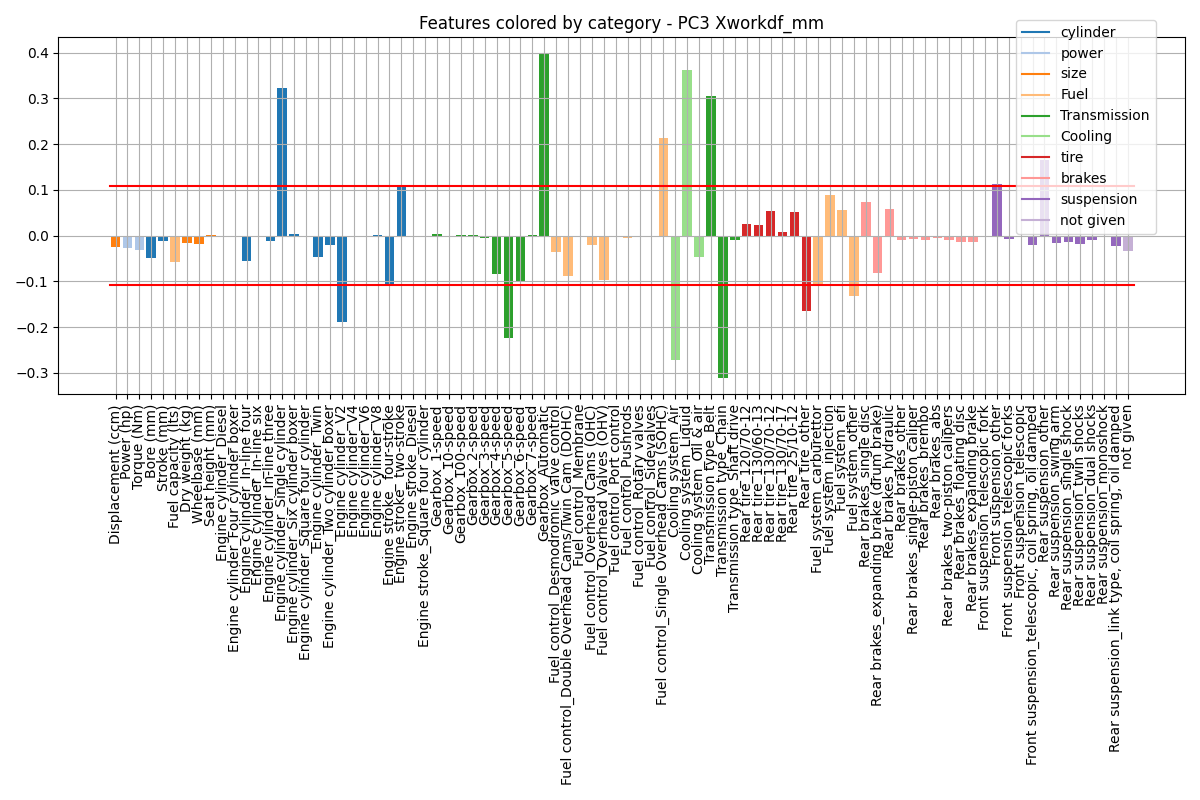


****************** PC3 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Engine cylinder_Single cylinder', 'Engine stroke_ two-stroke', 'Gearbox_Automatic', 'Fuel control_Single Overhead Cams (SOHC)', 'Cooling system_Liquid', 'Transmission type_Belt', 'Front suspension_other', 'Rear suspension_other']

HIGH-VALUED NEGATIVE COMPONENTS: ['Engine cylinder_V2', 'Gearbox_5-speed', 'Cooling system_Air', 'Transmission type_Chain', 'Rear tire_other', 'Fuel system_carburettor', 'Fuel system_other']
*********************************************



In [40]:
#barplots of PCs with respect to units of measurement and categories coloring (minmaxscaler case)

eps = np.sqrt(1 / pca_es4_mm.n_features_)

features_colors_measures = [df_features_measures.loc[df_features_measures['features'] == s]['color'].values[0] for s in Xworkdf.columns]
features_colors_cat = [df_features_categories.loc[df_features_categories['features'] == s]['color'].values[0] for s in Xworkdf.columns]

meas_colors_legend = [Line2D([0], [0], color=meas_colors[k]) for k in meas_colors.keys()]
cat_colors_legend = [Line2D([0], [0], color=cat_colors[k]) for k in cat_colors.keys()]
for ii in range(m_mm):
    plt.figure(figsize=(12, 8))
    plt.bar(np.arange(pca_es4_mm.n_features_), pca_es4_mm.components_[ii, :], 
            color=features_colors_measures)
    plt.plot([-0.5, pca_es4_mm.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_es4_mm.n_features_ - 0.5], [-eps, -eps], 'red')
    plt.xticks(ticks=np.arange(pca_es4_mm.n_features_), 
               labels=Xworkdf.columns,
               rotation=90)
    plt.title(f'Features colored by measures - PC{ii + 1} Xworkdf_mm')
    plt.legend(meas_colors_legend, [k for k in meas_colors.keys()],loc=(0.85,0.5))
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    plt.bar(np.arange(pca_es4_mm.n_features_), pca_es4_mm.components_[ii, :], 
            color=features_colors_cat)
    plt.plot([-0.5, pca_es4_mm.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_es4_mm.n_features_ - 0.5], [-eps, -eps], 'red')
    plt.xticks(ticks=np.arange(pca_es4_mm.n_features_), 
               labels=Xworkdf.columns,
               rotation=90)
    plt.title(f'Features colored by category - PC{ii + 1} Xworkdf_mm')
    plt.legend(cat_colors_legend, [k for k in cat_colors.keys()],loc=(0.85,0.45))
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    ind_great_pos_PCii = np.argwhere(pca_es4_mm.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_es4_mm.components_[ii, :] <= -eps).flatten()
    great_pos_PCii = [Xworkdf.columns[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [Xworkdf.columns[i] for i in ind_great_neg_PCii]
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')

The same procedure was applied for MinMaxScaler. Here, the interpretation of PCs seems more intuitive and less specific. In fact, looking to ChatGPT it seems easier to associate each PC with a certain category of motorcycle, given the high-value sets of positive and negative components. The following names were given:

1. **PC1 MinMaxScaler: Scooters, standard (+) VS high performance, sport (-) motorcycles**  
This PC separate motorcycles from the performance point of view (similarly to PC1 in the StandardScaler case). Automatic gearbox, air cooling system, carburettor fuel system and rear drum brake (all with positive PC1 component) are typical features of scooters and standard motorcycles while 6-speed gearbox, liquid cooling system, injection fuel system and single disc rear brake (all with negative PC1 component) are more common in high performance motorcycles.

2. **PC2 MinMaxScaler: Road (+) VS Dirt (-) motorcycles**  
PC2 characterizes motorcycles according to their type of use. Most characterizing features are: engine cylinder, stroke, transmission type and fuel system. V2 cylinder with four-stroke engines and belt/shaft drive transmissions are typical of Cruiser or Touring motorcycles (negative PC1 component) while single cylinder, two-strokes engine and chain transmission are more common in off road and motocross bikes (positive PC1 component).

3. **PC3 MinMaxScaler: Automatic shifting (+) VS Manual shifting motorcycles**  
This PC differentiates motorcycles depending on their type of shifting. Belt transmission is commonly found in automatic shifting motorcycles while chain transmission refers usually to manual shifting. Also the type of cooling system influences gearbox. In fact, liquid cooling system has got a positive PC1 component and is typically related with high performance motorcycles that often have got manual shifting. 

Differently from the StandardScaler case, here no PCs have a significative contribute for 'not given' feature.


*************************
Possible values of categories in the initial workdf are: ['Scooter', 'ATV', 'Allround', 'Sport', 'Enduro / offroad', 'Super motard', 'Custom / cruiser', 'Cross / motocross', 'Naked bike', 'Touring', 'Sport touring', 'Trial', 'Minibike, cross', 'Classic', 'Minibike, sport', 'Prototype / concept model']
*************************



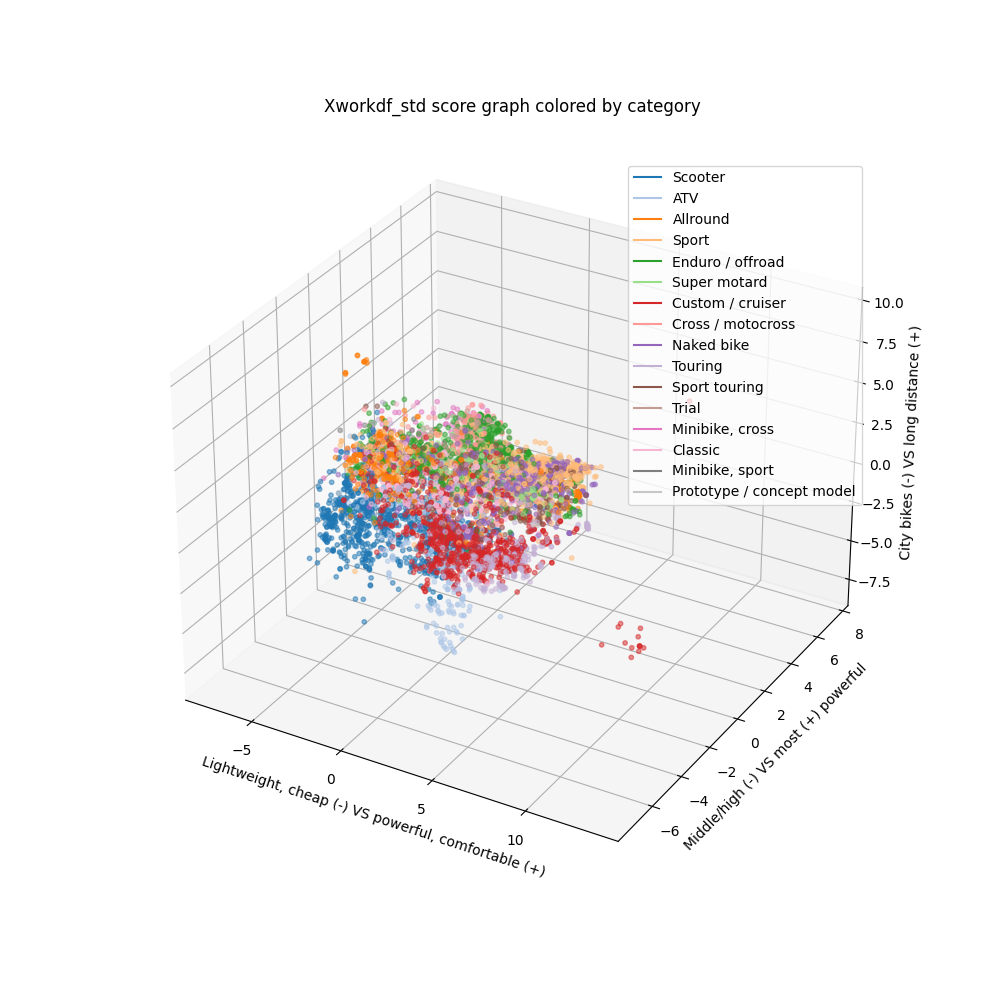

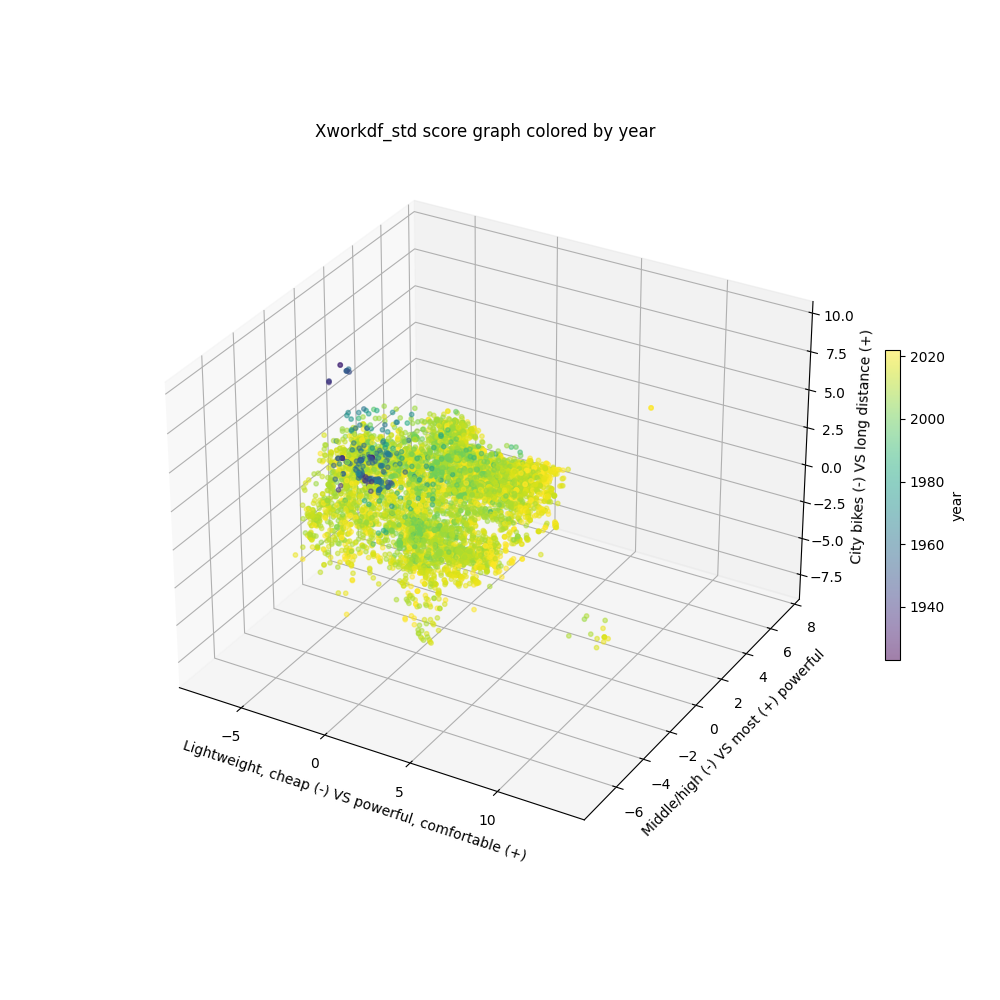

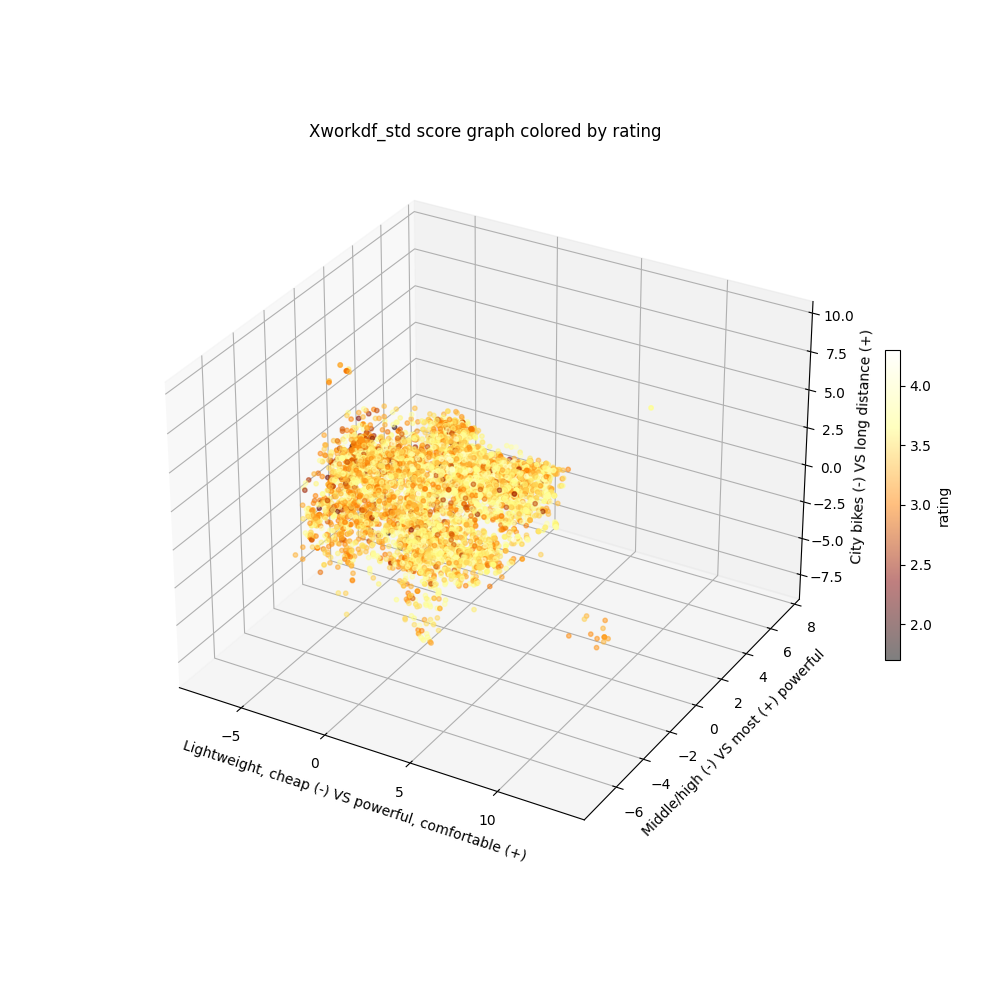

In [41]:
#score graphs colored by labels category, year and rating (standardscaler case)

cat = workdf['Category'].unique()
print('')
print('*************************')
print(f'Possible values of categories in the initial workdf are: {list(cat)}')
print('*************************')
print('')
cat_colors = {cat[i]: set20[i] for i in range(len(cat))}
workdf['color'] = [cat_colors[t] for t in workdf['Category'].values]

Ystd = pca_es4_std.transform(Xworkdf_std)

cat_colors_legend = [Line2D([0], [0], color=cat_colors[k]) for k in cat_colors.keys()]
sg_3d = plt.figure(figsize=(10, 10))
ax_sg_3d = sg_3d.add_subplot(111, projection='3d')
ax_sg_3d.scatter(Ystd[:, 0], Ystd[:, 1], Ystd[:, 2], s=10, 
                 c=workdf['color'].values, alpha=0.5)
plt.title('Xworkdf_std score graph colored by category')
ax_sg_3d.set_xlabel('Lightweight, cheap (-) VS powerful, comfortable (+)')
ax_sg_3d.set_ylabel('Middle/high (-) VS most (+) powerful')
ax_sg_3d.set_zlabel('City bikes (-) VS long distance (+)')
plt.legend(cat_colors_legend, [k for k in cat_colors.keys()],loc=(0.65,0.5))
plt.grid()
plt.show()

sg_3d = plt.figure(figsize=(10, 10))
ax_sg_3d = sg_3d.add_subplot(111, projection='3d')
imm=ax_sg_3d.scatter(Ystd[:, 0], Ystd[:, 1], Ystd[:, 2], s=10, 
                     c=workdf['Year'].values, cmap='viridis', alpha=0.5)
plt.title('Xworkdf_std score graph colored by year')
ax_sg_3d.set_xlabel('Lightweight, cheap (-) VS powerful, comfortable (+)')
ax_sg_3d.set_ylabel('Middle/high (-) VS most (+) powerful')
ax_sg_3d.set_zlabel('City bikes (-) VS long distance (+)')
plt.colorbar(imm,fraction=0.02,label='year')
plt.grid()
plt.show()

sg_3d = plt.figure(figsize=(10, 10))
ax_sg_3d = sg_3d.add_subplot(111, projection='3d')
imm=ax_sg_3d.scatter(Ystd[:, 0], Ystd[:, 1], Ystd[:, 2], s=10, 
                     c=workdf['Rating'].values, cmap='afmhot', alpha=0.5)
plt.title('Xworkdf_std score graph colored by rating')
ax_sg_3d.set_xlabel('Lightweight, cheap (-) VS powerful, comfortable (+)')
ax_sg_3d.set_ylabel('Middle/high (-) VS most (+) powerful')
ax_sg_3d.set_zlabel('City bikes (-) VS long distance (+)')
plt.colorbar(imm,fraction=0.02, label='rating')
plt.grid()
plt.show()

**PCA score graphs with StandardScaler preprocessing** confirm what we already know after PCs naming phase. In particular, samples plotted in three-dimensional space are quite well separated basing on their category. Coherently with the meaning of PCs, categories Scooters and Allround have got low PC1 value while Sport, Custom and Touring have got high PC1 value. similar reasonings can be applied for PC2 whereas PC3 mainly emphasizes the difference between Scooters/ATV from all other categories.  

Score graphs with respect to year and rating are also useful to identify which areas of $\mathbb{R}^3$ are more related to new and good motorcycles. In general we can say that having low component of PC1 is typical for older and worse motorcycles. PC2 gives instead an **important consequence** that can result profitable **from a company point of view**. Low PC2 values are associated to older motorbikes, however, it can be observed that lowest ratings are found with PC2$\approx$0 and not negative. This could mean that, for example, customers will prefer either basic and cheaper motorcycles or high performance and expensive ones, rather than motorbikes that lie somewhere in between this two extremes. Looking finally at PC3 it does not split well motorcycles basing on rating. The reason for this is that the initial dataset has got lots of rating missing values, so it is difficult to assess correctly their real values.

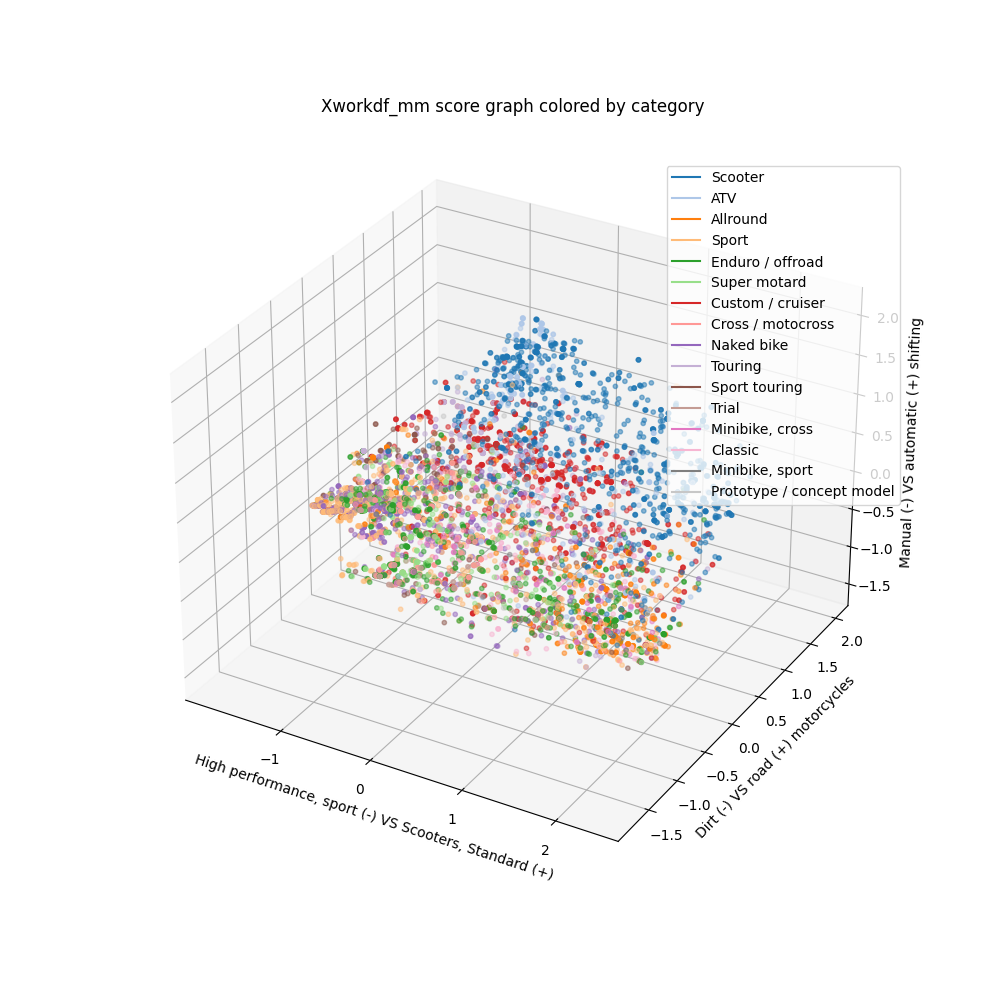

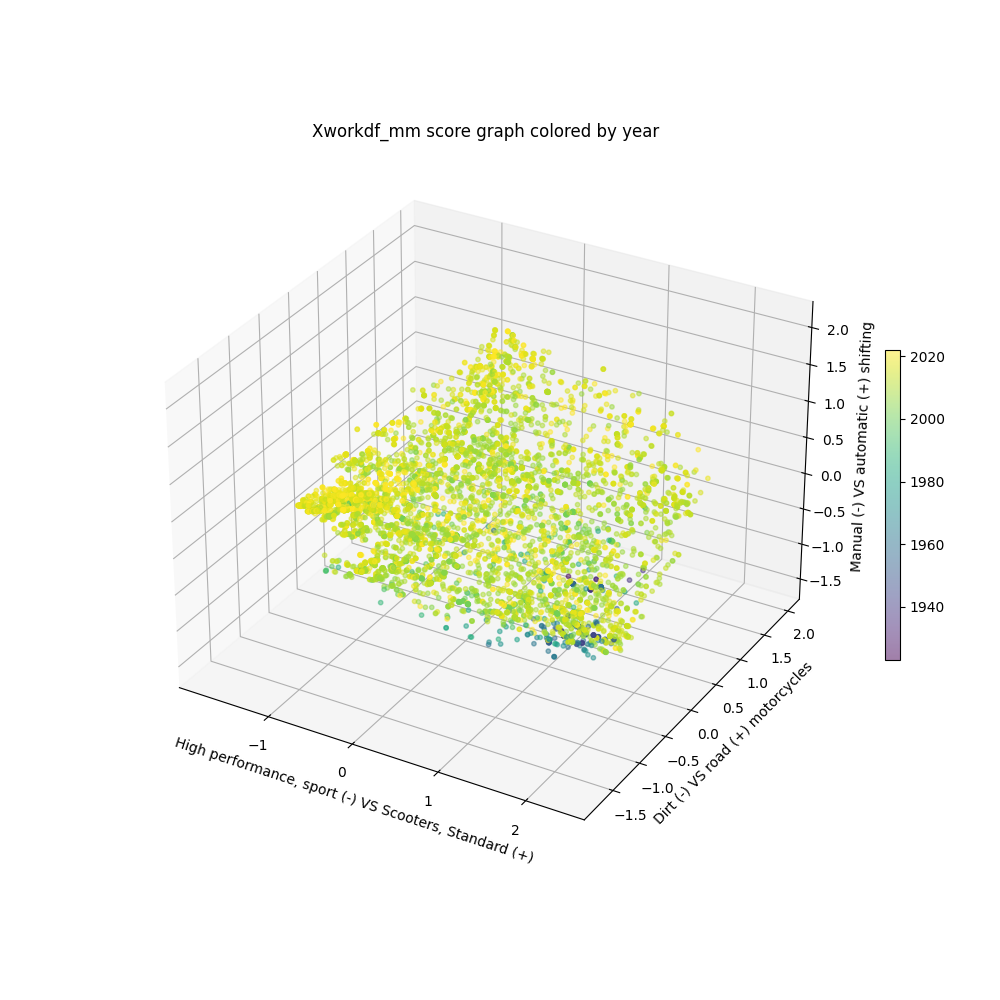

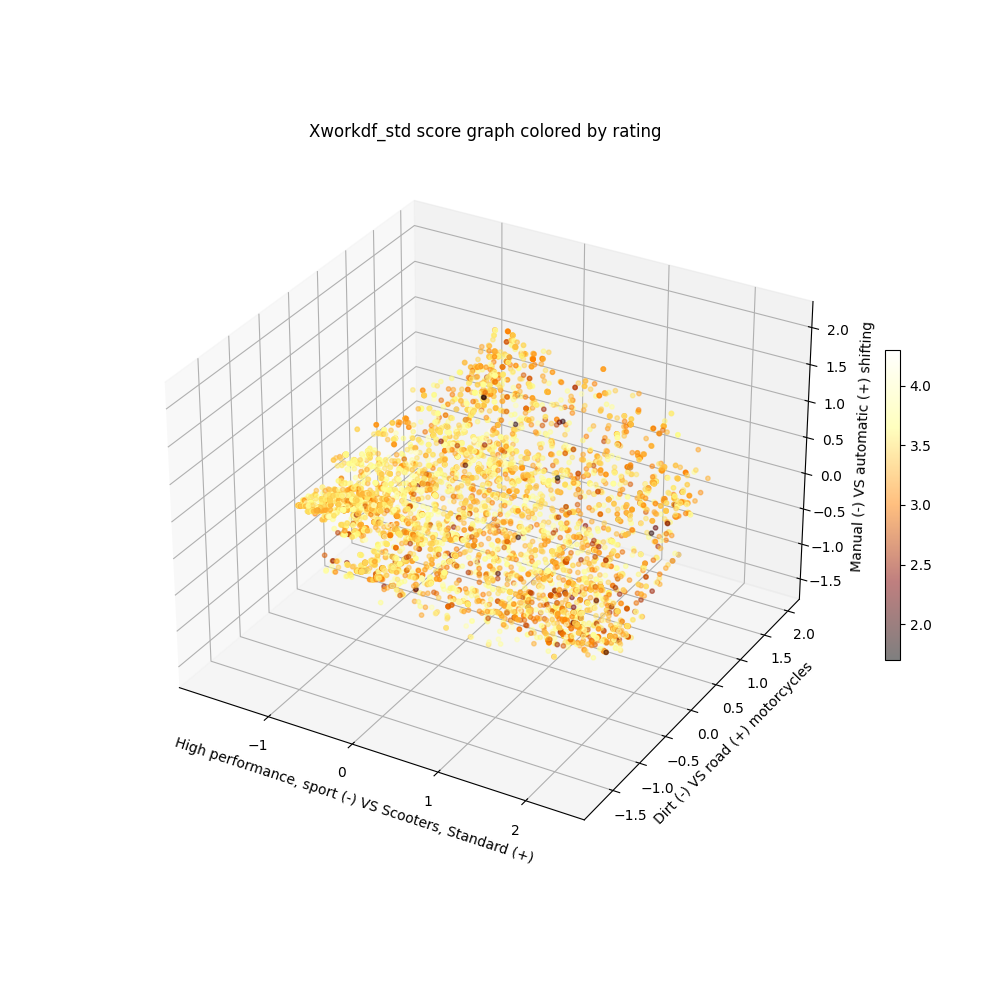

In [42]:
#score graphs colored by labels category, year and rating (minmaxscaler case)

Ymm = pca_es4_mm.transform(Xworkdf_mm)

cat_colors_legend = [Line2D([0], [0], color=cat_colors[k]) for k in cat_colors.keys()]
sg_3d = plt.figure(figsize=(10, 10))
ax_sg_3d = sg_3d.add_subplot(111, projection='3d')
ax_sg_3d.scatter(Ymm[:, 0], Ymm[:, 1], Ymm[:, 2], s=10, 
                 c=workdf['color'].values, alpha=0.5)
plt.title('Xworkdf_mm score graph colored by category')
ax_sg_3d.set_xlabel('High performance, sport (-) VS Scooters, Standard (+)')
ax_sg_3d.set_ylabel('Dirt (-) VS road (+) motorcycles')
ax_sg_3d.set_zlabel('Manual (-) VS automatic (+) shifting')
plt.legend(cat_colors_legend, [k for k in cat_colors.keys()],loc=(0.7,0.5))
plt.grid()
plt.show()

sg_3d = plt.figure(figsize=(10, 10))
ax_sg_3d = sg_3d.add_subplot(111, projection='3d')
imm=ax_sg_3d.scatter(Ymm[:, 0], Ymm[:, 1], Ymm[:, 2], s=10, 
                     c=workdf['Year'].values, cmap='viridis', alpha=0.5)
plt.title('Xworkdf_mm score graph colored by year')
ax_sg_3d.set_xlabel('High performance, sport (-) VS Scooters, Standard (+)')
ax_sg_3d.set_ylabel('Dirt (-) VS road (+) motorcycles')
ax_sg_3d.set_zlabel('Manual (-) VS automatic (+) shifting')
plt.colorbar(imm,fraction=0.02)
plt.grid()
plt.show()

sg_3d = plt.figure(figsize=(10, 10))
ax_sg_3d = sg_3d.add_subplot(111, projection='3d')
imm=ax_sg_3d.scatter(Ymm[:, 0], Ymm[:, 1], Ymm[:, 2], s=10, 
                     c=workdf['Rating'].values, cmap='afmhot', alpha=0.5)
plt.title('Xworkdf_std score graph colored by rating')
ax_sg_3d.set_xlabel('High performance, sport (-) VS Scooters, Standard (+)')
ax_sg_3d.set_ylabel('Dirt (-) VS road (+) motorcycles')
ax_sg_3d.set_zlabel('Manual (-) VS automatic (+) shifting')
plt.colorbar(imm,fraction=0.02)
plt.grid()
plt.show()

**PCA score graphs with MinMaxScaler preprocessing** bring quite good results. Samples colored by categories are still well separated but they seem more sparse and less attached to each other in $\mathbb{R}^3$. However, this can be said only from a graphical point of view, since the range of PCs possible values is not so wide. PCs names are almost related to defined categories types, so it is easy to see in the score graph which are samples with similar features. Better analysis can be done looking at plots colored with respect to year and rating. Newer motorcycles are well separated from older ones thanks to PC3 component. In fact, it is intuitive that older motorcycles are those with manual rather than automatic transmissions. Score graph colored by rating highlights something important from a marketing point of view: worse motorcycles are the ones with high PC1 and moreless negative PC2 component. This means that more **standard and Off road motorcycles are least liked** motorcycles among consumers. Further analysis can be conducted to study this topic. It is useful observe that the following result can be seen only with MinMaxScaler preprocessing and not with StandardScaler. 

## Excercise 5 (k-Means)

In this section I run the $k$-Means algorithm with respect to the projected samples in $\mathbb{R}^3$ and for both types of preprocessing. I decided to apply a 5-fold gridsearch cross validation to find combination of hyperparameters that give highest silhouette coefficient. Apart from searching the best number of clusters, I have added also the tuning of hyperparameters $\textit{n_init}$ (number of times $k$-means algorithm is run with different centroid seeds) and $\textit{algorithm}$ (type of algorithm to use). I choose only to tune these two hyperparameters because **$k$-means is susceptible to the initialization**, so, by running it multiple times I can afford robust results. In addition, trying different algorithms may improve final results also. Also $\textit{init}$ hyperparameter is related to the initialization method, however I decided to maintain it as $\textit{k-means++}$ because this method already speeds up convergence.

In [43]:
#kmeans gridsearch in the PC space (standardscaler case)

parameters = {'n_clusters':(3,4,5,6,7,8,9,10),
              'n_init':(10,20),'algorithm':('auto','full','elkan')}
def silhouette_scorer(estimator, X):
    labels = estimator.predict(X)
    return silhouette_score(X, labels)
km=KMeans(random_state=rs)
gridstd=GridSearchCV(estimator=km,
                  param_grid=parameters,
                  scoring=silhouette_scorer)
gridstd.fit(Ystd)
pd.DataFrame(gridstd.cv_results_).sort_values(by=['rank_test_score']).iloc[:10,:]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
37       0.441807      0.023139         0.133659        0.007859   
20       0.698670      0.015695         0.129519        0.006178   
21       1.489562      0.045207         0.141112        0.008577   
36       0.236924      0.043662         0.143261        0.019846   
4        0.345161      0.235501         0.155687        0.043270   
5        0.457017      0.048930         0.136919        0.011640   
7        0.517859      0.102398         0.147268        0.019196   
23       1.539035      0.108810         0.138453        0.019716   
39       0.661206      0.193503         0.149642        0.021507   
19       1.408669      0.067673         0.131675        0.007663   

   param_algorithm param_n_clusters param_n_init  \
37           elkan                5           20   
20            full                5           10   
21            full                5           20   
36           elkan                5           10   
4             auto                5           10   
5             auto                5           20   
7             auto                6           20   
23            full                6           20   
39           elkan                6           20   
19            full                4           20   

                                               params  split0_test_score  \
37  {'algorithm': 'elkan', 'n_clusters': 5, 'n_ini...           0.288862   
20  {'algorithm': 'full', 'n_clusters': 5, 'n_init...           0.288862   
21  {'algorithm': 'full', 'n_clusters': 5, 'n_init...           0.288862   
36  {'algorithm': 'elkan', 'n_clusters': 5, 'n_ini...           0.288862   
4   {'algorithm': 'auto', 'n_clusters': 5, 'n_init...           0.288862   
5   {'algorithm': 'auto', 'n_clusters': 5, 'n_init...           0.288862   
7   {'algorithm': 'auto', 'n_clusters': 6, 'n_init...           0.256985   
23  {'algorithm': 'full', 'n_clusters': 6, 'n_init...           0.256985   
39  {'algorithm': 'elkan', 'n_clusters': 6, 'n_ini...           0.256985   
19  {'algorithm': 'full', 'n_clusters': 4, 'n_init...           0.253347   

    split1_test_score  split2_test_score  split3_test_score  \
37           0.370586           0.370955           0.332106   
20           0.370586           0.370955           0.332106   
21           0.370586           0.370955           0.332106   
36           0.370586           0.370955           0.332106   
4            0.370586           0.370955           0.332106   
5            0.370586           0.370955           0.332106   
7            0.330715           0.344679           0.263437   
23           0.330715           0.344679           0.263437   
39           0.330715           0.344679           0.263437   
19           0.296300           0.330793           0.281589   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
37           0.314103         0.335322        0.032039                1  
20           0.314103         0.335322        0.032039                1  
21           0.314103         0.335322        0.032039                1  
36           0.314103         0.335322        0.032039                1  
4            0.314103         0.335322        0.032039                1  
5            0.314103         0.335322        0.032039                1  
7            0.264383         0.292040        0.037626                7  
23           0.264383         0.292040        0.037626                7  
39           0.264383         0.292040        0.037626                7  
19           0.278707         0.288147        0.025410               10

In [44]:
#kmeans gridsearch in the PC space (minmaxscaler case)

gridmm=GridSearchCV(estimator=km,
                  param_grid=parameters,
                  scoring=silhouette_scorer)
gridmm.fit(Ymm)
pd.DataFrame(gridmm.cv_results_).sort_values(by=['rank_test_score']).iloc[:10,:]

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
23       1.702407      0.214992         0.150567        0.023224   
22       0.796587      0.172154         0.141558        0.014889   
7        0.498996      0.046901         0.161387        0.019271   
6        0.239361      0.087429         0.158778        0.020015   
38       0.174632      0.029893         0.128619        0.006218   
39       0.383224      0.026068         0.131348        0.011869   
5        0.338689      0.030370         0.148821        0.009916   
21       1.406308      0.048624         0.128050        0.005069   
37       0.293167      0.020385         0.124095        0.002400   
36       0.151310      0.015410         0.135614        0.007964   

   param_algorithm param_n_clusters param_n_init  \
23            full                6           20   
22            full                6           10   
7             auto                6           20   
6             auto                6           10   
38           elkan                6           10   
39           elkan                6           20   
5             auto                5           20   
21            full                5           20   
37           elkan                5           20   
36           elkan                5           10   

                                               params  split0_test_score  \
23  {'algorithm': 'full', 'n_clusters': 6, 'n_init...           0.412889   
22  {'algorithm': 'full', 'n_clusters': 6, 'n_init...           0.412889   
7   {'algorithm': 'auto', 'n_clusters': 6, 'n_init...           0.412889   
6   {'algorithm': 'auto', 'n_clusters': 6, 'n_init...           0.412889   
38  {'algorithm': 'elkan', 'n_clusters': 6, 'n_ini...           0.412889   
39  {'algorithm': 'elkan', 'n_clusters': 6, 'n_ini...           0.412889   
5   {'algorithm': 'auto', 'n_clusters': 5, 'n_init...           0.393970   
21  {'algorithm': 'full', 'n_clusters': 5, 'n_init...           0.393970   
37  {'algorithm': 'elkan', 'n_clusters': 5, 'n_ini...           0.393970   
36  {'algorithm': 'elkan', 'n_clusters': 5, 'n_ini...           0.393970   

    split1_test_score  split2_test_score  split3_test_score  \
23           0.442798           0.447589           0.467416   
22           0.442798           0.447589           0.467416   
7            0.442798           0.447589           0.467416   
6            0.442798           0.447589           0.467416   
38           0.442798           0.447589           0.467416   
39           0.442798           0.447589           0.467416   
5            0.442124           0.418367           0.434180   
21           0.442124           0.418367           0.434180   
37           0.442124           0.418367           0.434180   
36           0.441215           0.418367           0.433850   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
23           0.414623         0.437063        0.020751                1  
22           0.414623         0.437063        0.020751                1  
7            0.414623         0.437063        0.020751                1  
6            0.414623         0.437063        0.020751                1  
38           0.414623         0.437063        0.020751                1  
39           0.414623         0.437063        0.020751                1  
5            0.394911         0.416710        0.019729                7  
21           0.394911         0.416710        0.019729                7  
37           0.394911         0.416710        0.019729                7  
36           0.394843         0.416449        0.019452               10

The Best combination of hyperparameters in the StandardScaler case is: $\textit{algorithm}$=$\textit{elkan}$, $\textit{n_clusters}$=5, $\textit{n_init}$=20 (mean silhouette coefficient=0.335322).  
The Best combination of hyperparameters in the MinMaxScaler case is: $\textit{algorithm}$=$\textit{full}$, $\textit{n_clusters}$=6, $\textit{n_init}$=20 (mean silhouette coefficient=0.437063).

## Excercise 6 (Cluster and Centroid Interpretation and Visulization)

In this section I made an analysis about clusters and centroids obtained with the best combination of hyperparameters for both prepocessing adopted.

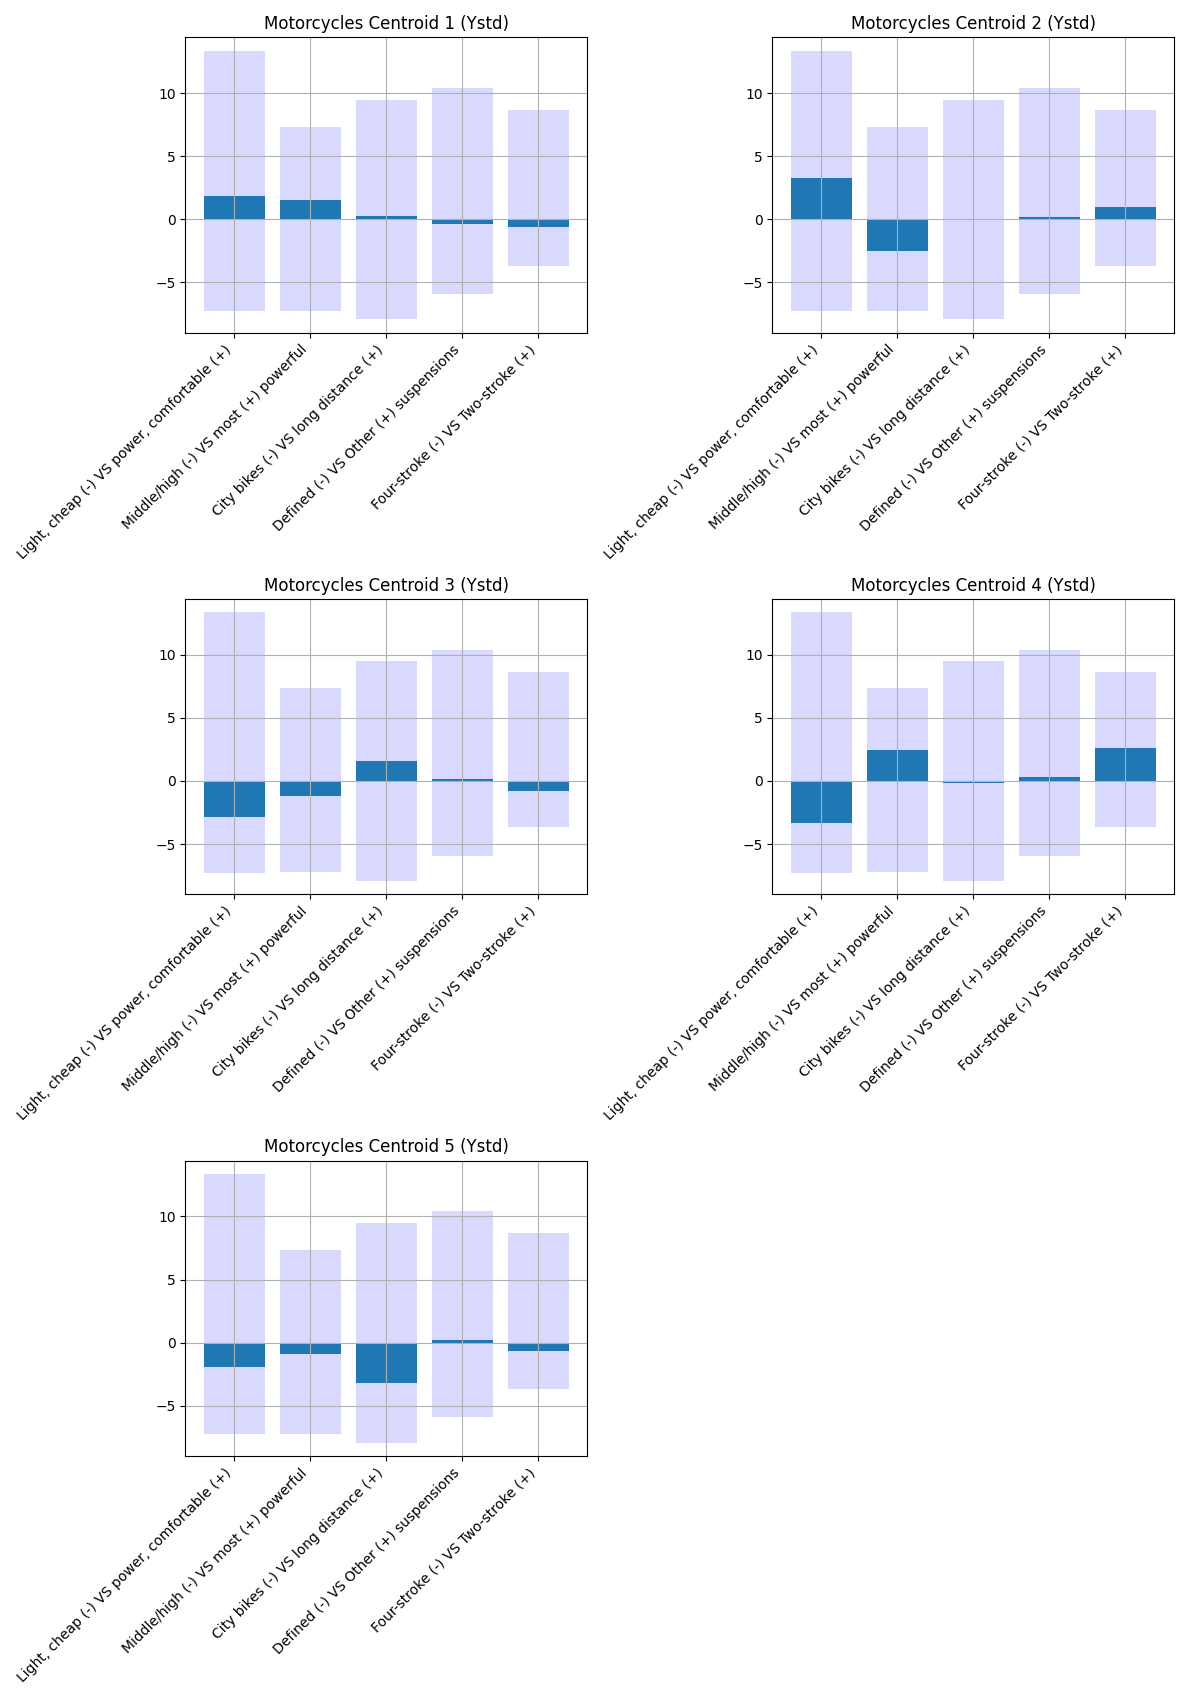

In [45]:
#centroids barplots with respect to the PC space (standardscaler case)

pc_names=['Light, cheap (-) VS power, comfortable (+)',
          'Middle/high (-) VS most (+) powerful',
          'City bikes (-) VS long distance (+)',
          'Defined (-) VS Other (+) suspensions',
          'Four-stroke (-) VS Two-stroke (+)']
maxs_y = Ystd.max(axis=0) 
mins_y = Ystd.min(axis=0) 

fig_centroids, ax_centroids = plt.subplots(3, 2, figsize=(12, 17))
for ii in range(gridstd.best_params_['n_clusters']):
    ir = ii // 2
    ic = ii % 2
    ax_centroids[ir, ic].bar(np.arange(gridstd.best_estimator_.cluster_centers_.shape[1]), 
                             maxs_y, color='blue', alpha=0.15)
    ax_centroids[ir, ic].bar(np.arange(gridstd.best_estimator_.cluster_centers_.shape[1]), 
                             mins_y, color='blue', alpha=0.15)
    ax_centroids[ir, ic].bar(np.arange(gridstd.best_estimator_.cluster_centers_.shape[1]), 
                             gridstd.best_estimator_.cluster_centers_[ii, :])
    ax_centroids[ir, ic].set_xticks(ticks=np.arange(gridstd.best_estimator_.cluster_centers_.shape[1]))
    ax_centroids[ir, ic].set_xticklabels(labels=pc_names, rotation=45,horizontalalignment='right')
    ax_centroids[ir, ic].grid(visible=True, which='both')
    plt.tight_layout()
    ax_centroids[ir, ic].set_title(f'Motorcycles Centroid {ii+1} (Ystd)')
fig_centroids.delaxes(ax_centroids[-1,-1])

Looking at barplots of centroids with respect to the PCs with StandardScaler preprocessing I gave them the following names:

1. **Centroid 1**: representer of most powerful motorcycles
2. **Centroid 2**: representer of touring motorcycles (comfortable and with middle/high power)
3. **Centroid 3**: representer of more standard motorcycles (lightweight with middle/high power and used more than just for local transportation)
4. **Centroid 4**: representer of motocross (lightweight, relatively cheap and powerful motorcycles)
5. **Centroid 5**: representer of scooters (lightweight, cheap and typical city motorbikes)

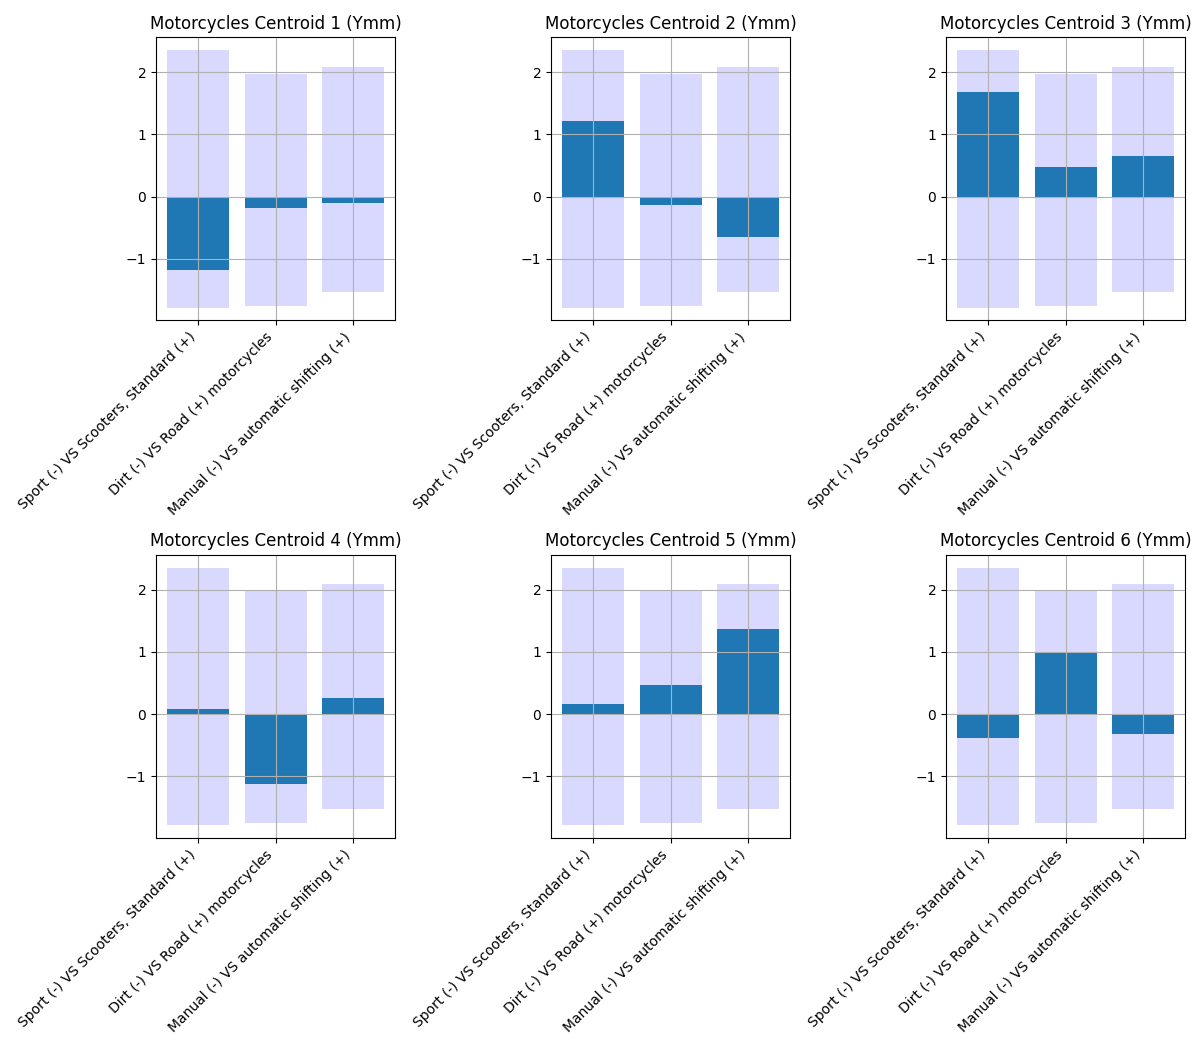

In [46]:
#centroids barplots with respect to the PC space (minmaxscaler case)

pc_names=['Sport (-) VS Scooters, Standard (+)',
          'Dirt (-) VS Road (+) motorcycles',
          'Manual (-) VS automatic shifting (+)']
maxs_y = Ymm.max(axis=0) 
mins_y = Ymm.min(axis=0) 

fig_centroids, ax_centroids = plt.subplots(2, 3, figsize=(12, 10.5))
for ii in range(gridmm.best_params_['n_clusters']):
    ir = ii // 3
    ic = ii % 3
    ax_centroids[ir, ic].bar(np.arange(gridmm.best_estimator_.cluster_centers_.shape[1]), 
                             maxs_y, color='blue', alpha=0.15)
    ax_centroids[ir, ic].bar(np.arange(gridmm.best_estimator_.cluster_centers_.shape[1]), 
                             mins_y, color='blue', alpha=0.15)
    ax_centroids[ir, ic].bar(np.arange(gridmm.best_estimator_.cluster_centers_.shape[1]), 
                             gridmm.best_estimator_.cluster_centers_[ii, :])
    ax_centroids[ir, ic].set_xticks(ticks=np.arange(gridmm.best_estimator_.cluster_centers_.shape[1]))
    ax_centroids[ir, ic].set_xticklabels(labels=pc_names, rotation=45,horizontalalignment='right')
    ax_centroids[ir, ic].grid(visible=True, which='both')
    plt.tight_layout()
    ax_centroids[ir, ic].set_title(f'Motorcycles Centroid {ii+1} (Ymm)')

Looking at barplots of centroids with respect to the PCs with MinMaxScaler preprocessing I gave them the following names:

1. **Centroid 1**: representer of high performance & sport motorcycles
2. **Centroid 2**: representer of standard motorcycles (with manual shifting)
3. **Centroid 3**: representer of scooters
4. **Centroid 4**: representer of motocross
5. **Centroid 5**: representer of a cluster with automatic shifting motorcycles (can include for example ATV, scooters and few types of touring)
6. **Centroid 6**: representer of touring motorcycles (slightly high performance and road motorcycles, mainly with manual shifting)

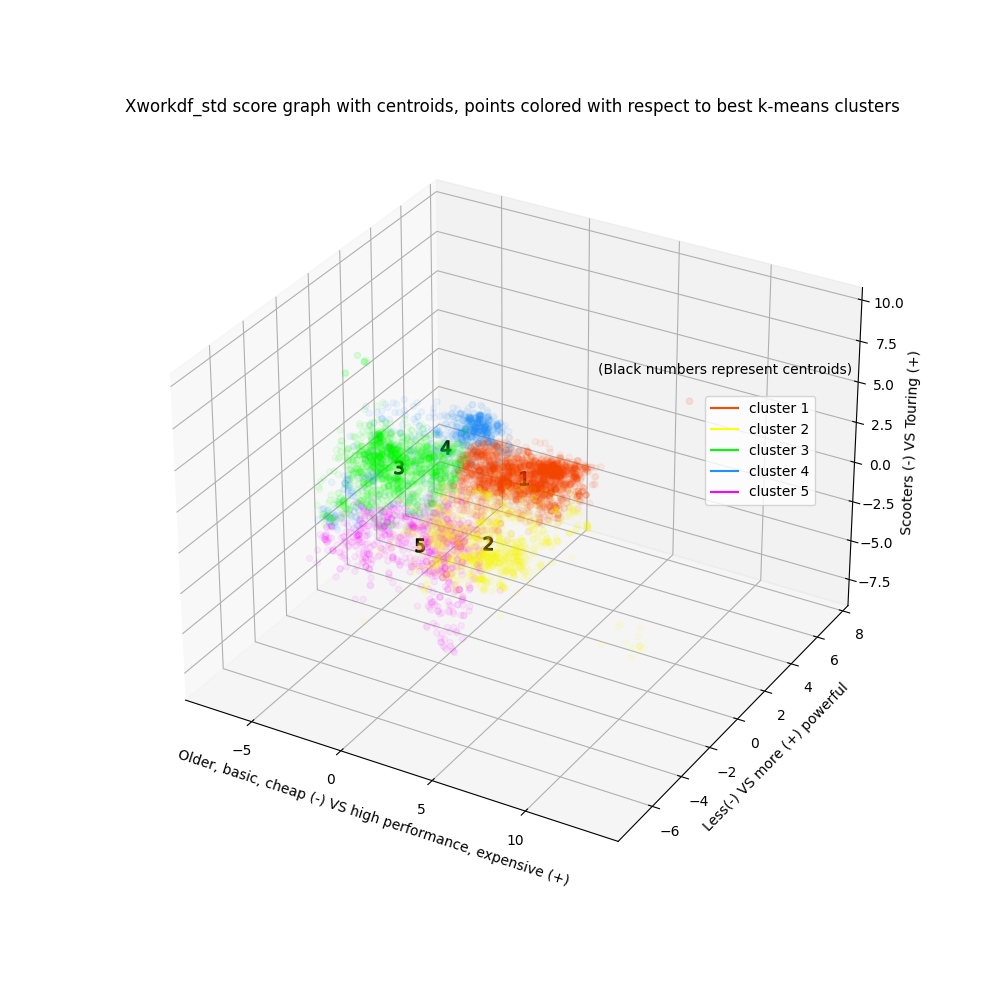

In [47]:
#PCA score graph with centroids in standardscaler case (points colored with respect to clusters)

markers=['$1$','$2$','$3$','$4$','$5$']
colorval = {0:'orangered',1:'yellow',2:'lime',
            3:'dodgerblue',4:'magenta',5:'saddlebrown'}
labels = gridstd.best_estimator_.labels_
colorlist = [colorval[a] for a in labels]
col_legend = [Line2D([0], [0], color=colorval[i]) for i in colorval.keys()]

sg_3d_km = plt.figure(figsize=(10,10))
ax_sg_3d_km = sg_3d_km.add_subplot(111, projection='3d')
ax_sg_3d_km.scatter(Ystd[:, 0], Ystd[:, 1], Ystd[:, 2], s=20, c=colorlist, alpha=0.06)
for i in range(gridstd.best_estimator_.cluster_centers_.shape[0]):
    ax_sg_3d_km.scatter(gridstd.best_estimator_.cluster_centers_[i,0],
                        gridstd.best_estimator_.cluster_centers_[i,1], 
                        gridstd.best_estimator_.cluster_centers_[i,2], 
                        s=90, marker=markers[i], c='black', alpha=1)
plt.title('Xworkdf_std score graph with centroids, points colored with respect to best k-means clusters')
ax_sg_3d_km.set_xlabel('Older, basic, cheap (-) VS high performance, expensive (+)')
ax_sg_3d_km.set_ylabel('Less(-) VS more (+) powerful')
ax_sg_3d_km.set_zlabel('Scooters (-) VS Touring (+)')
plt.legend(col_legend, [f'cluster {k+1}' for k in list(colorval.keys())[:-1]],loc=(0.75,0.5))
ax_sg_3d_km.text(4,4,5.5, "(Black numbers represent centroids)", color='black')
plt.grid()
plt.show()

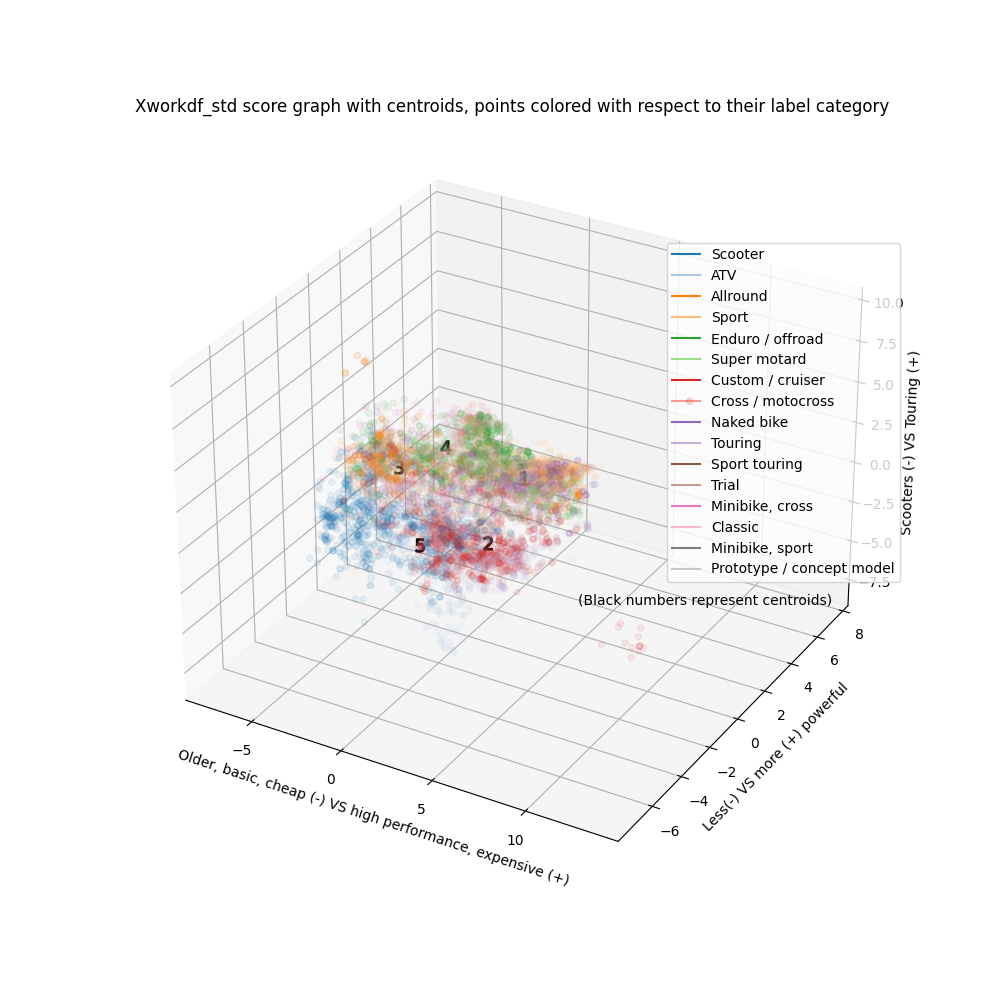

In [48]:
#PCA score graph with centroids in standardscaler case (points colored with respect to category label)

sg_3d_km = plt.figure(figsize=(10,10))
ax_sg_3d_km = sg_3d_km.add_subplot(111, projection='3d')
ax_sg_3d_km.scatter(Ystd[:, 0], Ystd[:, 1], Ystd[:, 2], s=20, c=workdf['color'].values, alpha=0.08)
for i in range(gridstd.best_estimator_.cluster_centers_.shape[0]):
    ax_sg_3d_km.scatter(gridstd.best_estimator_.cluster_centers_[i,0], 
                        gridstd.best_estimator_.cluster_centers_[i,1], 
                        gridstd.best_estimator_.cluster_centers_[i,2], 
                        s=90, marker=markers[i], c='black', alpha=1)
plt.title('Xworkdf_std score graph with centroids, points colored with respect to their label category')
ax_sg_3d_km.set_xlabel('Older, basic, cheap (-) VS high performance, expensive (+)')
ax_sg_3d_km.set_ylabel('Less(-) VS more (+) powerful')
ax_sg_3d_km.set_zlabel('Scooters (-) VS Touring (+)')
plt.legend(cat_colors_legend, [k for k in cat_colors.keys()],loc=(0.7,0.4))
ax_sg_3d_km.text(3,4,-9.5, "(Black numbers represent centroids)", color='black')
plt.grid()
plt.show()

Score graphs with centroids in StandardScaler preprocessing divides almost correctly motorcycles according to their categories. **Perspective may be misleading**, but looking at the plot from different angles it is possible to cluster in the proper way almost all samples. Few problems concern naked motorcycles, since they are moreless found between first and third cluster. This is something to be expected, since naked motorcycles are usually among the most powerful of standard motorcycles. Regarding the classification of allround motorcycles, it may be a subject for further study that they are grouped with lightweight motorcycles, although in reality their weight range may vary (maybe in our dataset there were only lightweight allround motorcycles).

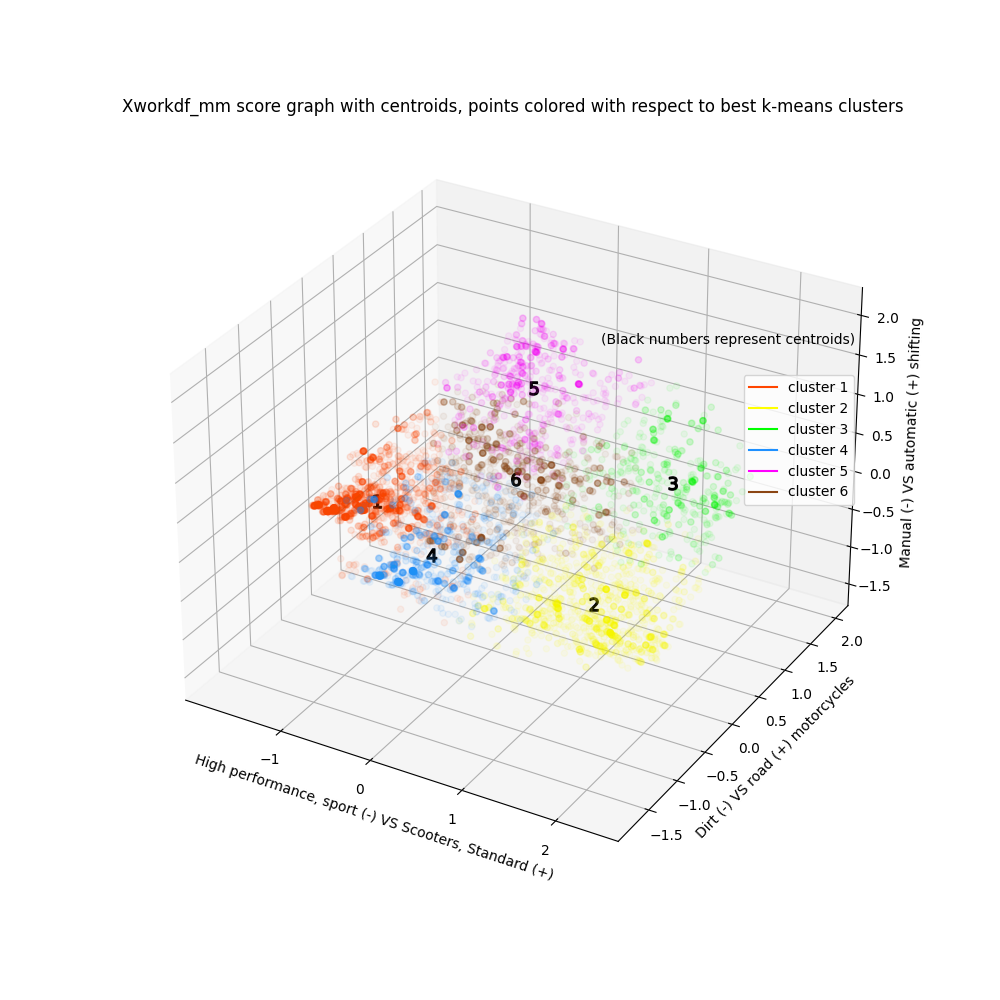

In [49]:
#PCA score graph with centroids in minmaxscaler case (points colored with respect to clusters)

markers=['$1$','$2$','$3$','$4$','$5$','$6$']
colorval = {0:'orangered',1:'yellow',2:'lime',
            3:'dodgerblue',4:'magenta',5:'saddlebrown'}
labels = gridmm.best_estimator_.labels_
colorlist = [colorval[a] for a in labels]
col_legend = [Line2D([0], [0], color=colorval[i]) for i in colorval.keys()]

sg_3d_km = plt.figure(figsize=(10,10))
ax_sg_3d_km = sg_3d_km.add_subplot(111, projection='3d')
imm=ax_sg_3d_km.scatter(Ymm[:, 0], Ymm[:, 1], Ymm[:, 2], s=20, c=colorlist, alpha=0.06)
for i in range(gridmm.best_estimator_.cluster_centers_.shape[0]):
    ax_sg_3d_km.scatter(gridmm.best_estimator_.cluster_centers_[i,0], 
                        gridmm.best_estimator_.cluster_centers_[i,1], 
                        gridmm.best_estimator_.cluster_centers_[i,2], 
                        s=90, marker=markers[i], c='black', alpha=1)
plt.title('Xworkdf_mm score graph with centroids, points colored with respect to best k-means clusters')
ax_sg_3d_km.set_xlabel('High performance, sport (-) VS Scooters, Standard (+)')
ax_sg_3d_km.set_ylabel('Dirt (-) VS road (+) motorcycles')
ax_sg_3d_km.set_zlabel('Manual (-) VS automatic (+) shifting')
plt.legend(col_legend, [f'cluster {k+1}' for k in colorval.keys()],loc=(0.8,0.5))
ax_sg_3d_km.text(0.7,0.8,1.9, "(Black numbers represent centroids)", color='black')
plt.grid()
plt.show()

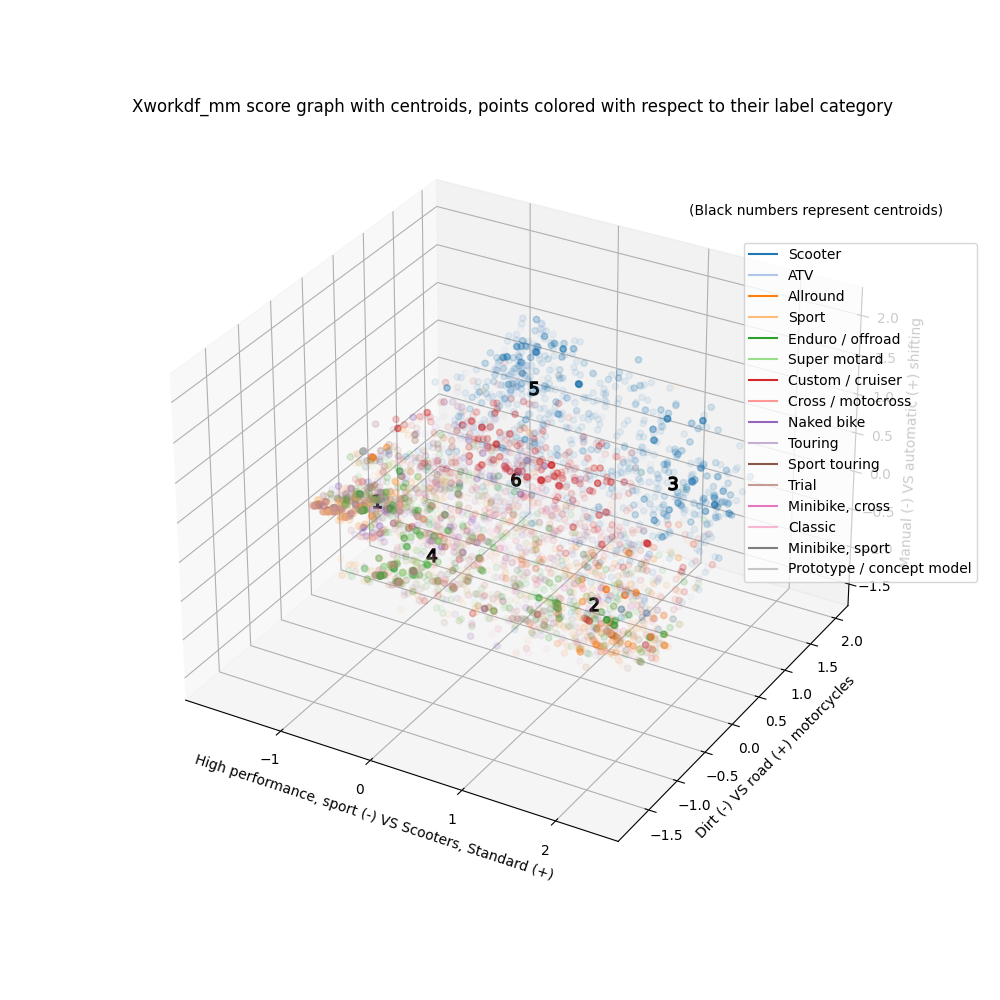

In [50]:
#PCA score graph with centroids in minmaxscaler case (points colored with respect to category label)

sg_3d_km = plt.figure(figsize=(10,10))
ax_sg_3d_km = sg_3d_km.add_subplot(111, projection='3d')
ax_sg_3d_km.scatter(Ymm[:, 0], Ymm[:, 1], Ymm[:, 2], 
                    s=20, c=workdf['color'].values, alpha=0.08)
for i in range(gridmm.best_estimator_.cluster_centers_.shape[0]):
    ax_sg_3d_km.scatter(gridmm.best_estimator_.cluster_centers_[i,0], 
                        gridmm.best_estimator_.cluster_centers_[i,1], 
                        gridmm.best_estimator_.cluster_centers_[i,2], 
                        s=90, marker=markers[i], c='black', alpha=1)
plt.title('Xworkdf_mm score graph with centroids, points colored with respect to their label category')
ax_sg_3d_km.set_xlabel('High performance, sport (-) VS Scooters, Standard (+)')
ax_sg_3d_km.set_ylabel('Dirt (-) VS road (+) motorcycles')
ax_sg_3d_km.set_zlabel('Manual (-) VS automatic (+) shifting')
plt.legend(cat_colors_legend, [k for k in cat_colors.keys()],loc=(0.8,0.4))
ax_sg_3d_km.text(1.5,1,3.6, "(Black numbers represent centroids)", color='black')
plt.grid()
plt.show()

Despite the fact of having higher cross validation mean silhouette score, it seems that MinMaxScaler preprocessing returns worse graphical results. Again, perspective is tricky also in this case. Rotating the plot it is possible to observe that motorcycles are quite well separated according to their categories. The only **problem** is related to **enduro motorcycles**, since they are sparse between clusters 1, 2 and 4 (but with prevalence in cluster 4, which is the correct one).  

Comparing last plot with the same one in StandardScaler case may arise a question about if it is correct to separate the scooter category into two clusters. StandardScaler preprocessing put all samples in just one cluster while here they are separated into two: the fifth cluster regards more agile and powerful scooters while the third one concern more standard ones (this can be deduced by looking at meaning of the clusters closest to the fifth and third). For this purpose it can be useful to study silhouette scores of clusters centroids in both preprocessing and compare them.

In [51]:
#computation of centroids silhouette scores for both preprocessing

labelmm=gridmm.best_estimator_.labels_
labelstd=gridstd.best_estimator_.labels_
clustermm_index=[]
clusterstd_index=[]

for c in range(gridmm.best_estimator_.cluster_centers_.shape[0]):
    clustermm_index.append([i for i,n in enumerate(labelmm) if n==c])
for c in range(gridstd.best_estimator_.cluster_centers_.shape[0]):
    clusterstd_index.append([i for i,n in enumerate(labelstd) if n==c])
    
silhmm_samples=silhouette_samples(Ymm,labelmm)
silhstd_samples=silhouette_samples(Ystd,labelstd)
silhmm_centroids=[np.mean(silhmm_samples[clustermm_index[i]]) for i in range(gridmm.best_estimator_.cluster_centers_.shape[0])]
silhstd_centroids=[np.mean(silhstd_samples[clusterstd_index[i]]) for i in range(gridstd.best_estimator_.cluster_centers_.shape[0])]
df=pd.DataFrame(index=[f'silhouette score centroid {i+1}' for i in range(gridmm.best_estimator_.cluster_centers_.shape[0])], 
                columns=['MinMaxScaler','StandardScaler'])
df['MinMaxScaler']=silhmm_centroids
df.iloc[:5,1]=silhstd_centroids
df

MinMaxScaler StandardScaler
silhouette score centroid 1      0.491351       0.387429
silhouette score centroid 2      0.398836       0.262623
silhouette score centroid 3      0.435601       0.274936
silhouette score centroid 4      0.449683       0.377068
silhouette score centroid 5      0.438259       0.264559
silhouette score centroid 6      0.348068            NaN

It seems clear that MinMaxScaler preproccesing outperforms StandardScaler one in terms of internal evaluation of centroids. This suggest that it may be better to consider the two clusters about scooters as separated. Further external evaluation can be made in order to obtain stronger results.